# 02a_ Introduction to Photometric Correction for Auxtel

- author Sylvie Dagoret-Campagne
- creation date : 2024/01/03
- last verification : 2024/01/04

### Use libraries

- getObsAtmo : for atmosphere emulation : https://github.com/LSSTDESC/getObsAtmo/tree/main
- rubinsimphot : a simplified version of rubin_sim : https://github.com/sylvielsstfr/rubinsimphot

### Goal :

- Introduce the key quantities to measure band by band over the different visit exposures,
- Simple formula for correction flux/magnitude at each visit for any knwon attenuations in bands,
- Separate a 0th order band attenuation from a 1st order SED-shape correction depending on the source SED,
- Required accuracy on atmospheric parameters from the constraint from the 0th order band attenuation
- 1st order color correction evaluated on different sources --> see next notebooks 02b,...02e,...

### Conda environnement
- conda_py310 (on laptop)
- at USDF:
  
         newpythonpath = os.path.join(os.getenv("HOME"),"repos/repos_w_2023_44/rubinsimphot/src")
         import sys
         sys.path.append(newpythonpath)

# Reference :
FGCM in DES

Forward Global Photometric calibration of the dark energy surver
D.L. Burke et al., 2017
https://arxiv.org/abs/1706.01542

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.colors as colors
import matplotlib.cm as cmx
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import LogNorm
from matplotlib.gridspec import GridSpec
import pandas as pd

import matplotlib.ticker                         # here's where the formatter is
import os,sys
import re
import pandas as pd

plt.rcParams["figure.figsize"] = (8,6)
plt.rcParams["axes.labelsize"] = 'xx-large'
plt.rcParams['axes.titlesize'] = 'xx-large'
plt.rcParams['xtick.labelsize']= 'xx-large'
plt.rcParams['ytick.labelsize']= 'xx-large'


In [2]:
from scipy import interpolate

In [3]:
machine_name = os.uname().nodename

if 'sdf' in machine_name:
    #machine_name_usdf = 'sdfrome001'
    print("Set environement for USDF")
    newpythonpath = os.path.join(os.getenv("HOME"),"repos/repos_w_2023_44/rubinsimphot/src")
    sys.path.append(newpythonpath)
elif 'mac' in machine_name:
    print("Be sure to run this notebook in conda environnement named conda_py310")
else:
    print("Your current machine name is {machine_name}. Check your python environment")

Be sure to run this notebook in conda environnement named conda_py310


## Imports dedicated to this work

- import the atmospheric transparency emulator (instead of using libradtran code).
- import rubin sim
- import libPhotometricCorrections : encapsulate uninteresting calculation details

### libradtran Emulator

In [4]:
from importlib.metadata import version
the_ver = version('getObsAtmo')
print(f"Version of getObsAtmo : {the_ver}")

Version of getObsAtmo : 0.1.1


In [5]:
from getObsAtmo import ObsAtmo
emul = ObsAtmo("AUXTEL")

AUXTEL site name validated as LSST observatory


In [6]:
WL = emul.GetWL()

#### Library to fit atmosphere

In [7]:
import sys
sys.path.append('../lib')
#import libAtmosphericFit

#### Library that encapsulate calculations for Photometric correction

In [8]:
# This package encapsulate the calculation on calibration used in this nb
from libPhotometricCorrections_auxtel import *

LSST site name validated as LSST observatory


#### library rubin_sim defining LSST parameters, namely for photometric calculations

In [9]:
from rubinsimphot.phot_utils import Bandpass, Sed
from rubinsimphot.data import get_data_dir

## Configuration

## Standard atmosphere

The following numbers are taken from a fit on the standard atmosphere defined in rubin_sim

In [10]:
am0 =1.20    # airmass
pwv0 = 5.0  # Precipitable water vapor vertical column depth in mm
oz0 = 300.  # Ozone vertical column depth in Dobson Unit (DU)
ncomp=1     # Number of aerosol components
tau0= 0.04 # Vertical Aerosol depth (VAOD) 
beta0 = 1.2 # Aerosol Angstrom exponent

### Initialisation of Atmospheric corrections

In [11]:
pc = PhotometricCorrections(am0,pwv0,oz0,tau0,beta0)

/Users/dagoret/MacOSX/GitHub/LSST/AtmosphericSimulation/rubinsimphot/src/rubinsimphot/phot_utils/bandpass.py:68: UserWarning: Wavelength sampling of 1.0 nm is > 0.2 nm, this may not work well with a Sed object. Consider resampling with resample_bandpass method.
  warnings.warn(


In [12]:
! ls  /Users/dagoret/rubin_sim_data/throughputs/

2MASS                baseline             panStarrs
README.md            hipparcos            sdss
WISE                 imsim                tycho
approximate_baseline johnson
atmos                megacam


### Check standard atmosphere

Text(0.5, 1.0, 'Standard atmosphere transmission')

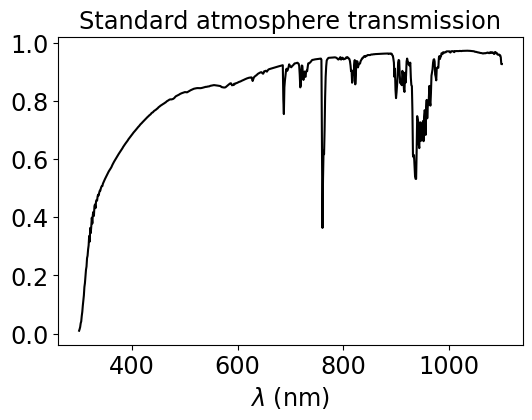

In [13]:
fig, axs = plt.subplots(1,1,figsize=(6,4))
axs.plot(pc.WL,pc.atm_std,'k-')
axs.set_xlabel("$\\lambda$ (nm)")
axs.set_title("Standard atmosphere transmission")

### Check LSST instrument throughput

Photometric Correction package should find the instrumental passband of LSST

Text(0.5, 1.0, 'Instrument throughput (auxtel)')

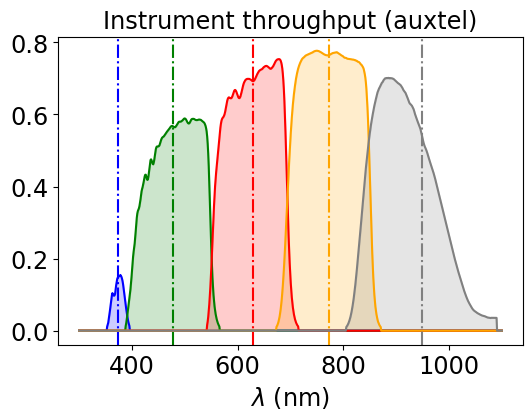

In [14]:
fig, axs = plt.subplots(1,1,figsize=(6,4))
# loop on filter
for index,f in enumerate(filter_tagnames):
    
    axs.plot(pc.bandpass_inst[f].wavelen,pc.bandpass_inst[f].sb,color=filter_color[index]) 
    axs.fill_between(pc.bandpass_inst[f].wavelen,pc.bandpass_inst[f].sb,color=filter_color[index],alpha=0.2) 
    axs.axvline(FILTERWL[index,2],color=filter_color[index],linestyle="-.")
    
axs.set_xlabel("$\\lambda$ (nm)")
axs.set_title("Instrument throughput (auxtel)")

### Check LSST standard Filter throughputs

- instrument + atmosphere

Text(0.5, 1.0, 'Total filter throughput (auxtel)')

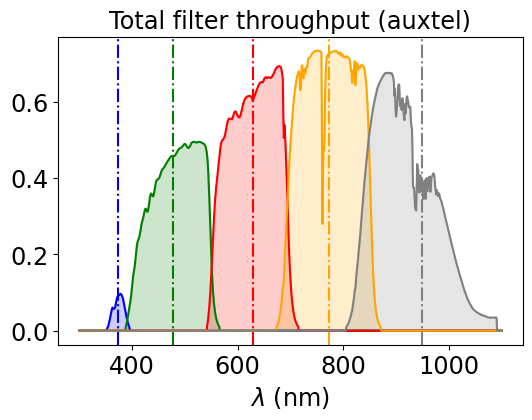

In [15]:
fig, axs = plt.subplots(1,1,figsize=(6,4))
# loop on filter
for index,f in enumerate(filter_tagnames):
    
    axs.plot(pc.bandpass_total_std[f].wavelen,pc.bandpass_total_std[f].sb,color=filter_color[index]) 
    axs.fill_between(pc.bandpass_total_std[f].wavelen,pc.bandpass_total_std[f].sb,color=filter_color[index],alpha=0.2) 
    axs.axvline(FILTERWL[index,2],color=filter_color[index],linestyle="-.")
    
axs.set_xlabel("$\\lambda$ (nm)")
axs.set_title("Total filter throughput (auxtel)")

### Check standard normalised filter total response


The normalised filter is a key concept introduced in rubin_sim. It is very sensitive to the filter shape, not the attenuation. Thus it is important on SED dependent color corrections, where $S_b^{std}(\lambda)$ is the total transmission in band $b$ (instrument + atmosphere) for a standard atmosphere.

$$
\phi_b^{std}(\lambda) = \frac{S_b^{std}(\lambda) \frac{1}{\lambda}}{\int S_b^{std}(\lambda) \frac{d\lambda}{\lambda}}
$$

Text(0.5, 1.0, 'Normalised filter total response $\\phi_b^{std}(\\lambda)$ (auxtel)')

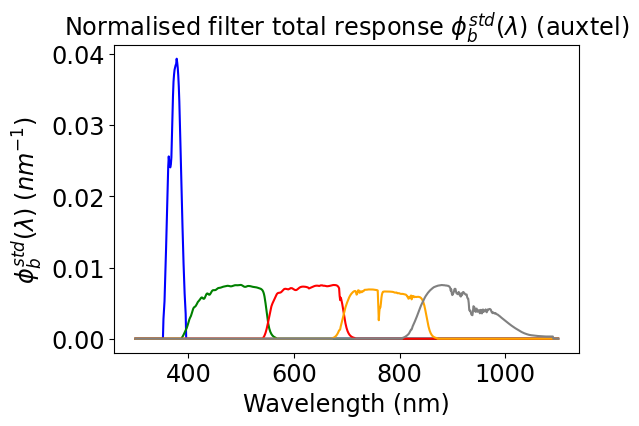

In [16]:
fig, ax = plt.subplots(1,1,figsize=(6,4))
for index,f in enumerate(filter_tagnames):
    ax.plot(pc.WL,pc.phiArray_std[index,:],'-',color=filter_color[index],label = f)
ax.set_xlabel('Wavelength (nm)')
ax.set_ylabel("$\phi_b^{std}(\lambda)\; (nm^{-1})$ ")
ax.set_title("Normalised filter total response $\phi_b^{std}(\lambda)$ (auxtel)")

## Introduction and Review on Photometric corrections

### Reminder on what kind of flux we want to calculate 

- the Flux in each band $b$ at the TOP of atmosphere

$$
F_{b\;AB}^{std} = \frac{1}{F_{0}} \int \phi_{b}^{std}(\lambda) F_\nu({\lambda})d\lambda
$$

where:
- $F_{0}$ is a constant such as $F_0^{AB}=3631$ Jy with $1 Jy = 10^{-23} erg.cm^{-2}.s^{-1}.Hz^{-1}$,
- $F_\nu(\lambda)$ is the SED (Spectral Energy Distribution) of the object in Jansky unit. **In general $F_\nu(\lambda)$ is unknown or poorly known after identification/classification of the object,** 
- $\phi_{b}^{std}(\lambda)$ : is the standard normalised response of the telescope (including atmosphere and hardware electronics and optics):

$$
\phi^{std}_b(\lambda) = \frac{S_b^{std}(\lambda) \frac{1}{\lambda}}{\int S_b^{std}(\lambda) \frac{d \lambda}{\lambda}}
$$

- $S_b^{std}(\lambda)$ is **the defined** LSST survey total transmission of the instrument + atmosphere, taken to be the most probable or average or median total transmission:
$$
S_b^{std}(\lambda) = S^{std}_{atm}(\lambda) \times S_{b\; inst}^{std}(\lambda)
$$
It is defined at a particular airmass, a particular atmospheric transmission (with a set a pre-defined atmospheric parameters) and a particular hardware-optics+electronics setting.


Note if $F_{b\; AB}^{std}$ is a quantity that we have to calculate from the known $\phi_b^{std}$, the true SED $F_\nu$ is in principle unknown : we have
to measure something !
This is the per exposure ADC photometric count in band $b$: 
$$
ADC_b^{std} = \frac{A \Delta T}{g_{el}h} \int S_{b}^{std}(\lambda) F_\nu(\lambda) \frac{d\lambda}{\lambda}
$$

- $ADC_b^{std}$ is the expected number of counts, after correction from Instrument Signature Removal, including CCD unflattening and aperture photometry on the object.
- $A$, $\Delta T$, $g_{el}$ are the instrument constants, respectively Surface collection, Exposure-time, electronic gain . They are much poorely known at the percent level.
- $h$ is the Planck constant.

The point is that we never measure ADC counts with a  $S_{b}^{std}(\lambda)$ transmission. We measure $ADC_b^{obs}$ (after ISR and unflattening on the image and aperture photometry on the object) for each visit of the object
for a also measured transmission $S_{b}^{obs}(\lambda)$.

$$
ADC_b^{obs} = \frac{A \Delta T}{g_{el}h} \int S_{b}^{obs}(\lambda) F_\nu(\lambda) \frac{d\lambda}{\lambda}
$$

### Goal of Photometric Correction
**So the goal of Photometric correction is to calculate for each visit  the flux in the observed band $b$ : $F_{b\;AB}^{std}$ from the measured $ADC_b^{obs}$,
for a calibrated $S_b^{obs}(\lambda)$ or equivalently $\phi_b^{obs}(\lambda)$ given a defined $S_b^{std}(\lambda)$ or equivalently $\phi_b^{std}(\lambda)$.** 

After rearranging the above equation, one get the AB flux per visit in LSST standard band $b$:

$$
F_{b\; AB}^{std} = \frac{g_{el} h}{F_0 A \Delta T} \frac{ADU^{obs}_b}{\mathbb{I}_{0\,b}^{obs}} \frac{\int \phi_b^{std}(\lambda) F_\nu(\lambda) d\lambda}{\int \phi_b^{obs}(\lambda) F_\nu(\lambda) d\lambda}
$$

where the integral  $\mathbb{I}_{0\,b}^{obs}$ is defined as :
$$
\mathbb{I}_{0\,b}^{obs} = \int S_{b}^{obs}(\lambda) \frac{d\lambda}{\lambda} 
$$

- **The interpretation of $\mathbb{I}_{0\,b}^{obs}$ correspond to the calculation of an average attenuation in the $b$ band**.
This term compensates the variation of the band absorption measured $ADU_b^{obs}$, thus correcting at zeroth order $F_{b\; AB}^{std}$.

*Note if we don't know $S_b^{obs}(\lambda)$, we have to replace at zeros order the unknown integral  $\mathbb{I}_{0\,b}^{obs}$ by the known defined integral  $\mathbb{I}_{0\,b}^{std} = \int S_{b}^{std}(\lambda) \frac{d\lambda}{\lambda}$. However any variation of the absorption in the filter band $b$ would not be compensated.*

- The term of constants $\frac{g_{el} h}{F_0A \Delta T}$ is poorly known because we don't know these constants at the percent level (except $h$ and $F_0$). 
This term is referred as the instrumental zero point term. It is a calibration constant that must be determined by a dedicated Zero-point calibration procedure
for each visit, for each CCD from a series of calibration stars seen on the CCD plate. It is a kind of time dependent grey term to be applied band per band , CCD per CCD.

- The term $ \frac{\int \phi_b^{std}(\lambda) F_\nu(\lambda) d\lambda}{\int \phi_b^{obs}(\lambda) F_\nu(\lambda) d\lambda}$ refer explicitely to the unknown SED $F_\nu(\lambda)$. This is why one refer as the color term in the band $b$. This is term is expected to be colose to unity : 

- If observations conditions are close to standard condtions, this term is close to 1. 
- If the SED shape is close to that of a flat source, like an ideal AB source, this term is close to 1. 

However,
- If the SED has a sharp slope in the band, this term may not be negligible compared to the expected photometric accuracy.

This term seems to generate a bias in the flux. But on the contrary, it could bring additionnal information, because
we could measure it with serveral visits per object:

The we could aim to guess $F_\nu(\lambda)$ shape from the measured average $< F_{b\; AB}^{std} >$ for that object.
By expanding the SED shape at first order in the $b$ band:
$$
F_\nu(\lambda) \simeq F_\nu(\lambda_b)\left(1 +  f^{\prime}(\lambda_b)(\lambda- \lambda_b)\right)
$$



$$
F_{b\; AB}^{std} = \frac{g_{el} h}{F_0A \Delta T} \frac{ADU^{obs}_b}{\mathbb{I}_{0\,b}^{obs}} 
\left(1 + f^{\prime}(\lambda_b)(\Pi_{1\,b}^{std} -  \Pi_{1\,b}^{obs}) \right)
$$

where the integral $\mathbb{I}_{1\, b}$ is defined as :
$$
\mathbb{I}_{1\, b}^{obs} = \int (\lambda - \lambda_b) \phi_{b}^{obs}(\lambda) d\lambda
$$
$$
\mathbb{I}_{1\, b}^{std} = \int (\lambda - \lambda_b) \phi_{b}^{std}(\lambda) d\lambda
$$

where $\lambda_b$ is the average center of the $b$ band.

  Note the term $F_\nu(\lambda_b)$ is eliminated, only the relative derivative $f^\prime(\lambda_b) = \frac{1}{F_\nu(\lambda_b)}\frac{dF\nu}{d\lambda}(\lambda_b)$ matters.

*For example for conditions such that $obs \simeq std$, color corrections are small, one measure $F_{b\; AB}^{std}$ with low bias, whereas for conditions where $obs \neq std$, we estimate $f^\prime(\lambda_b)$.*

The standard magnitude per visit reads:

$$
m_{b\, AB}^{std} = -2.5 \log_{10}(ADU^{obs}_b) + 2.5 \log_{10} \frac{\Pi_{0\,b}^{obs}}{\Pi_{0\,b}^{std}} + \frac{2.5}{\ln(10)}f^{\prime}(\lambda_b)(\Pi_{1\,b}^{std} -  \Pi_{1\,b}^{obs}) + ZPT_b
$$


- $-2.5 \log_{10}(ADU^{obs}_b)$ is the instrumental magnitude,
- $2.5 \log_{10} \frac{\Pi_{0\,b}^{obs}}{\Pi_{0\,b}^{std}}$ is the zeros-th order correction for band relative attenuation (compared to standard attenuation),
- $\frac{2.5}{\ln(10)}f^{\prime}(\lambda_b)(\Pi_{1\,b}^{std} -  \Pi_{1\,b}^{obs})$ is the first-order color term correction
- $ZPT_b =  2.5 \log_{10} \left(\frac{F_0 A \Delta T}{g_{el} h} \right)  + 2.5 \log_{10}(\Pi_{0\,b}^{std})$ is the source independent and transmission variation independent zero point that does not need to be calculated to be evaluated CCD per CCD, visit per visit using several photometric calibration sources in LSST FOV.
(This is a kind of band Zero point, because we add the term $2.5 \log_{10}(\Pi_{0\,b}^{std}$ to the pure instrumental term.) 

## Summary on Photometric correction goals

We propose to calibrate sources Fluxes in AB unit, by correcting instrumental magnitudes, band by band, visit per visit independently. 
We are able to separate the contribution of the atmoshere attenuation even if the SED is unknown.
For this calibration we requires to monitor the transmission integrals :

- $2.5 \log_{10} \frac{\Pi_{0\,b}^{obs}}{\Pi_{0\,b}^{std}}$ to correct magnitude at zeros-th order for any band-average grey attenuation,
- $(\Pi_{1\,b}^{std} -  \Pi_{1\,b}^{obs})$ to correct magnitude at first order for SED average slope in the band,
  
  
- In addition a method to derive the photometrical zero point ZPT must be studied in this DEC-PC group (this subject is not adressed for the moment),

- Aperture Photometric accuracy including sky background contribution in $-2.5 \log_{10}(ADU^{obs}_b)$ is still an open field in DESC-PC group.

In this notebook, we focus on the impact of atmospheric variations on the two terms:
$2.5 \log_{10} \frac{\Pi_{0\,b}^{obs}}{\Pi_{0\,b}^{std}}$  and $(\Pi_{1\,b}^{std} -  \Pi_{1\,b}^{obs})$ 

# Numerical applications to Photometric corrections

## Airmass variation

### Observed atmospheric transmissions when varying airmass only

In [17]:
all_am = np.linspace(1,2.5,16)
NAM=len(all_am)
pwv= 5.0
oz = 300
ncomp =1
tau= 0.04
beta = 1

In [18]:
all_am_tags = []
for index,am in enumerate(all_am):
    am_tag = "am_"+str(int(am*10))
    all_am_tags.append(am_tag)
all_am_tags=np.array(all_am_tags)
all_am_tags

array(['am_10', 'am_11', 'am_12', 'am_13', 'am_14', 'am_15', 'am_16',
       'am_17', 'am_18', 'am_19', 'am_20', 'am_21', 'am_22', 'am_23',
       'am_24', 'am_25'], dtype='<U5')

In [19]:
pc.CalculateMultiObs(all_am,pwv,oz,tau,beta)

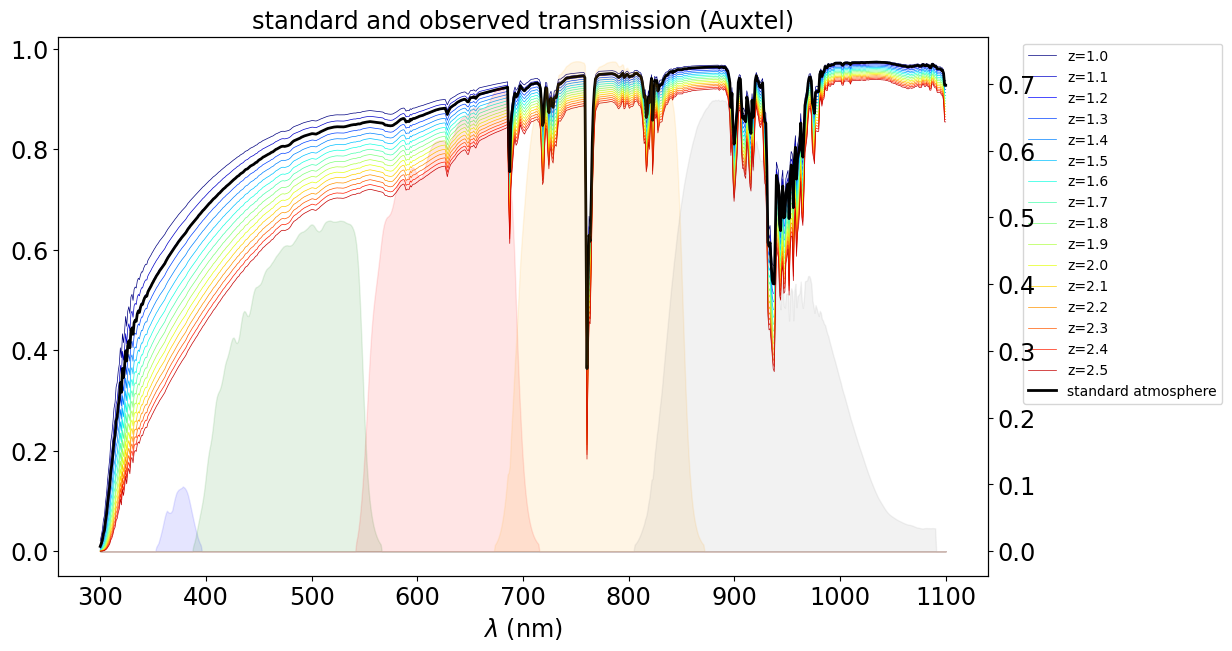

In [20]:
NOBS = len(all_am)

# wavelength bin colors
jet = plt.get_cmap('jet')
cNorm = colors.Normalize(vmin=0, vmax=NOBS)
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)
all_colors = scalarMap.to_rgba(np.arange(NOBS), alpha=1)


fig, axs = plt.subplots(1,1,figsize=(12,7))

for index,am in enumerate(all_am):
  
    atm = pc.coll_atm_nonstd[index]
    am = all_am[index]
    label = f"z={am:.1f}"
    
    
    axs.plot(pc.WL,atm,color=all_colors[index],label=label,lw=0.5)


    
axs.plot(pc.WL,pc.atm_std,color="k",lw=2,label="standard atmosphere")
axs.legend(bbox_to_anchor=(1.03, 1.0))  
axs.set_xlabel("$\lambda$ (nm)")
axs.set_title("standard and observed transmission (Auxtel)")


ax2 = axs.twinx()
for ifilt,f in enumerate(filter_tagnames):
    ax2.fill_between(pc.bandpass_total_std[f].wavelen,pc.bandpass_total_std[f].sb,color=filter_color[ifilt],alpha=0.1) 
    #ax2.set_yticks([])



#### Response in filters when varying airmass only

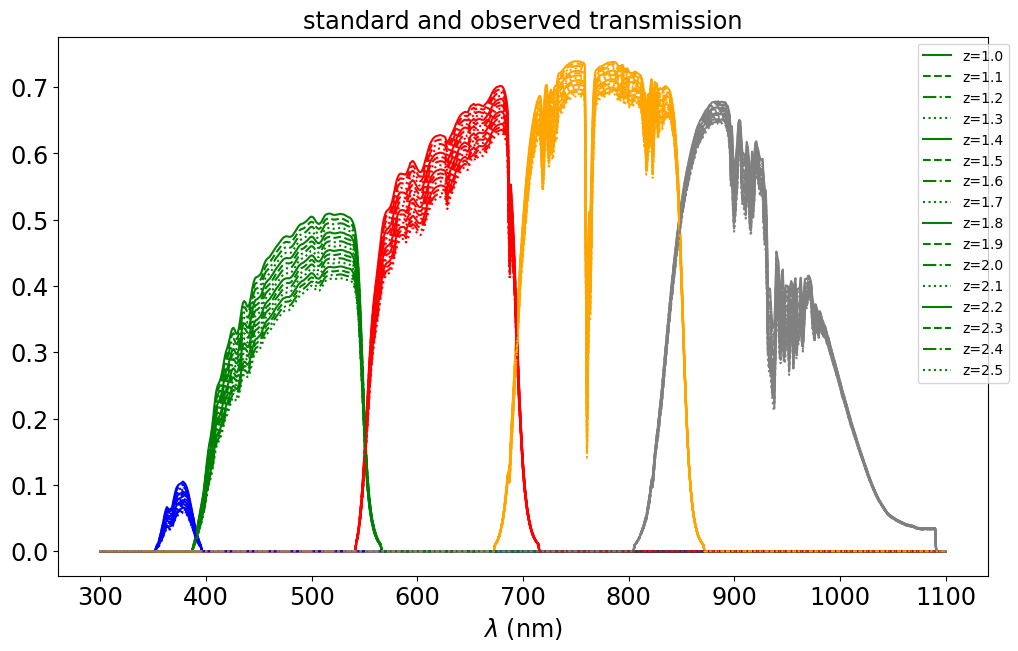

In [21]:
fig, axs = plt.subplots(1,1,figsize=(12,7))

all_linestyles = ['-','--','-.',':','-','--','-.',':','-','--','-.',':','-','--','-.',':']


for idx_am,am in enumerate(all_am):
    
    
    label = f"z={am:.1f}"
    
    for ifilt,f in enumerate(filter_tagnames):
        x=pc.coll_bandpass_total_nonstd[idx_am][f].wavelen
        y=pc.coll_bandpass_total_nonstd[idx_am][f].sb 
        
        if ifilt==1:
            axs.plot(x,y,color=filter_color[ifilt],linestyle=all_linestyles[idx_am],label=label )
        else:
            axs.plot(x,y,color=filter_color[ifilt],linestyle=all_linestyles[idx_am])

axs.set_xlabel("$\lambda$ (nm)")
axs.set_title("standard and observed transmission")
axs.legend(bbox_to_anchor=(1.03, 1.0))  

## Normalized response for airmass variation

/var/folders/79/hrybm_4s0zjd4jsb7lp_trhh0000gp/T/ipykernel_4553/1024041709.py:53: RuntimeWarning: invalid value encountered in divide
  the_ratio = the_y/the_y_std


Text(0.5, 1.0, 'Relative observed/standard normalized transmission')

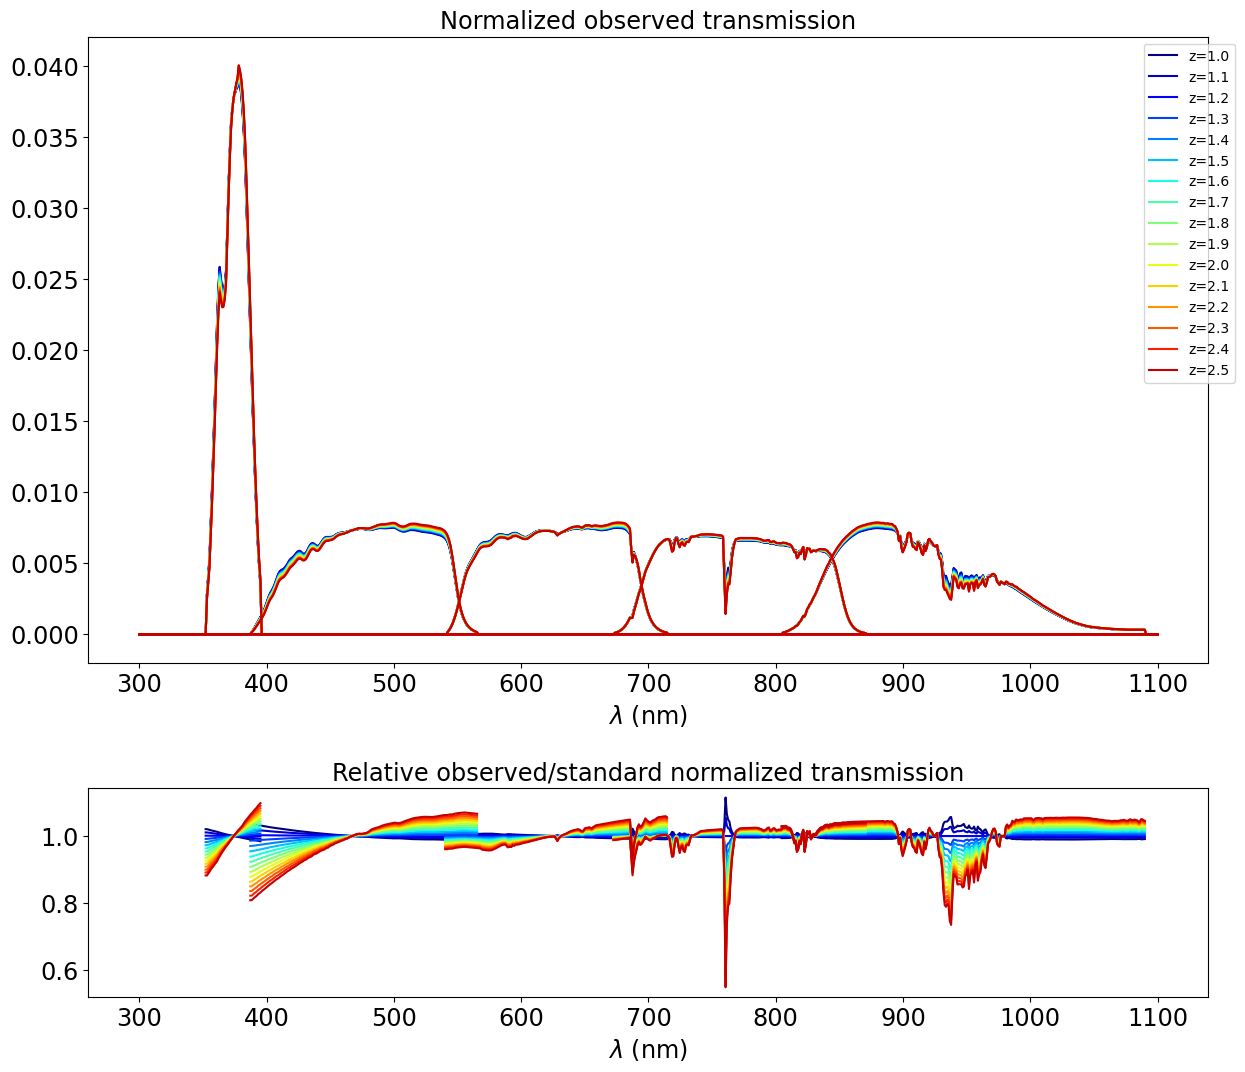

In [22]:
all_linestyles = ['-','--','-.',':','-','--','-.',':','-','--','-.',':','-','--','-.',':']

# wavelength bin colors
jet = plt.get_cmap('jet')
cNorm = colors.Normalize(vmin=0, vmax=NOBS)
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)
all_colors = scalarMap.to_rgba(np.arange(NOBS), alpha=1)



fig = plt.figure(figsize=(14,12))

gs = fig.add_gridspec(2, 1,  height_ratios=(3, 1),
                      left=0.1, right=0.9, bottom=0.1, top=0.9,
                      wspace=0.05, hspace=0.3)


axs = fig.add_subplot(gs[0, 0])

for idx_am,am in enumerate(all_am):
       
    label = f"z={am:.1f}"
    
    for ifilt,f in enumerate(filter_tagnames):
        
        the_x=pc.WL
        the_y=pc.coll_phiArray_nonstd[idx_am][ifilt,:]
        the_y_std = pc.phiArray_std[ifilt:,]
       
        
        if ifilt==1:
            axs.plot(the_x,the_y,color=all_colors[idx_am],linestyle="-",label=label )
        else:
            axs.plot(the_x,the_y,color=all_colors[idx_am],linestyle="-")

axs.set_xlabel("$\lambda$ (nm)")
axs.set_title("Normalized observed transmission")
axs.legend(bbox_to_anchor=(1.03, 1.0)) 

main_ax =axs

axs = fig.add_subplot(gs[1, 0],sharex=main_ax)

for idx_am,am in enumerate(all_am):
       
    label = f"z={am:.1f}"
    
    for ifilt,f in enumerate(filter_tagnames):
        
        the_x=pc.WL
        the_y=pc.coll_phiArray_nonstd[idx_am][ifilt,:]
        the_y_std = pc.phiArray_std[ifilt,:]
        the_ratio = the_y/the_y_std
       
        
        if ifilt==1:
            axs.plot(the_x,the_ratio,color=all_colors[idx_am],linestyle="-",label=label )
        else:
            axs.plot(the_x,the_ratio,color=all_colors[idx_am],linestyle="-")

axs.set_xlabel("$\lambda$ (nm)")
axs.set_title("Relative observed/standard normalized transmission")
#axs.legend(bbox_to_anchor=(1.03, 1.0)) 


- Impact of airmass variation on color correction arizes
mainly in **U,B, Y** filters at the level of tens percents

### Zero point for airmass variation

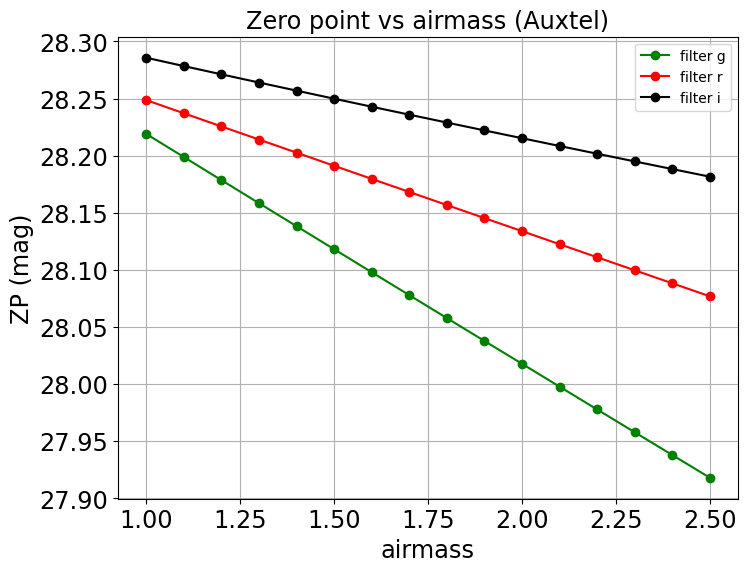

In [23]:
fig, ax = plt.subplots(1,1,figsize=(8,6))
ax.plot(all_am,pc.allcollperfilter['g']['ZPT_nonstd'],'o-g',label="filter g")
ax.plot(all_am,pc.allcollperfilter['r']['ZPT_nonstd'],'o-r',label="filter r")
ax.plot(all_am,pc.allcollperfilter['i']['ZPT_nonstd'],'o-k',label="filter i")
ax.set_title("Zero point vs airmass (Auxtel)")
ax.set_xlabel("airmass")
ax.set_ylabel("ZP (mag)")
ax.legend()
ax.grid()

### Airmass variation : Observed filter and normalized response

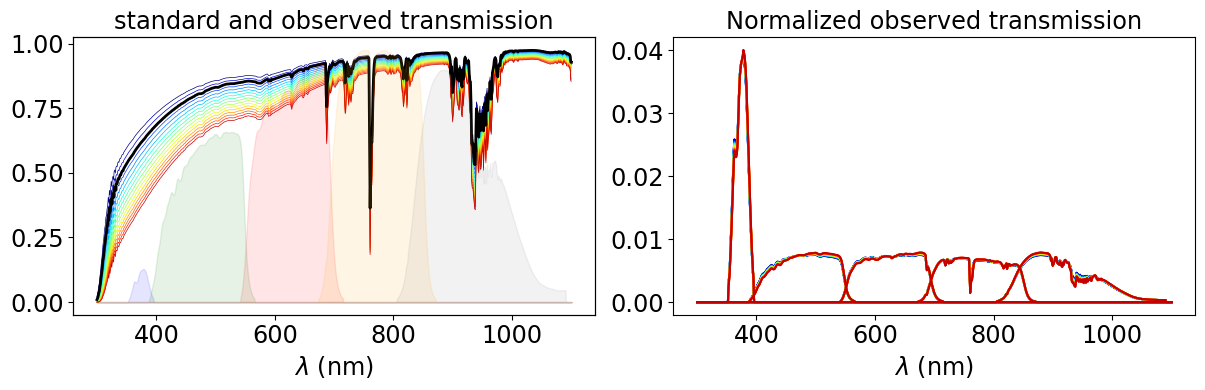

In [24]:
NOBS = len(all_am)

# wavelength bin colors
jet = plt.get_cmap('jet')
cNorm = colors.Normalize(vmin=0, vmax=NOBS)
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)
all_colors = scalarMap.to_rgba(np.arange(NOBS), alpha=1)


fig = plt.figure(figsize=(12,4))

# Figure 1
axs=fig.add_subplot(1,2,1)
for index,am in enumerate(all_am):
  
    atm = pc.coll_atm_nonstd[index]
    am = all_am[index]
    label = f"z={am:.1f}" 
    axs.plot(pc.WL,atm,color=all_colors[index],label=label,lw=0.5)
   
axs.plot(pc.WL,pc.atm_std,color="k",lw=2,label="standard atmosphere")
#axs.legend(bbox_to_anchor=(1.03, 1.0))  
axs.set_xlabel("$\lambda$ (nm)")
axs.set_title("standard and observed transmission")

ax2 = axs.twinx()
for ifilt,f in enumerate(filter_tagnames):
    ax2.fill_between(pc.bandpass_total_std[f].wavelen,pc.bandpass_total_std[f].sb,color=filter_color[ifilt],alpha=0.1) 
    ax2.set_yticks([])



# Figure 2
axs=fig.add_subplot(1,2,2)

all_linestyles = ['-','--','-.',':','-','--','-.',':','-','--','-.',':','-','--','-.',':']

# wavelength bin colors
jet = plt.get_cmap('jet')
cNorm = colors.Normalize(vmin=0, vmax=NOBS)
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)
all_colors = scalarMap.to_rgba(np.arange(NOBS), alpha=1)

for idx_am,am in enumerate(all_am):
       
    label = f"z={am:.1f}"
    
    for ifilt,f in enumerate(filter_tagnames):
        
        the_x=pc.WL
        the_y=pc.coll_phiArray_nonstd[idx_am][ifilt,:]
       
        
        if ifilt==1:
            axs.plot(the_x,the_y,color=all_colors[idx_am],linestyle="-",label=label )
        else:
            axs.plot(the_x,the_y,color=all_colors[idx_am],linestyle="-")

axs.set_xlabel("$\lambda$ (nm)")
axs.set_title("Normalized observed transmission")
#axs.legend(bbox_to_anchor=(1.03, 1.0))  

plt.tight_layout()
plt.show()


- we see on the same figure the two kinds of photometric corrections.
- Left : the atmospheric attenuation in each band
- Right : normalized response distorsion used in the the color correction. 

### airmass variation : $2.5 \log_{10} (II_0^{obs}(b)/II_0^{std}(b))$ and  $II_{1}^{std}(b)-II_{1}^{obs}(b)$

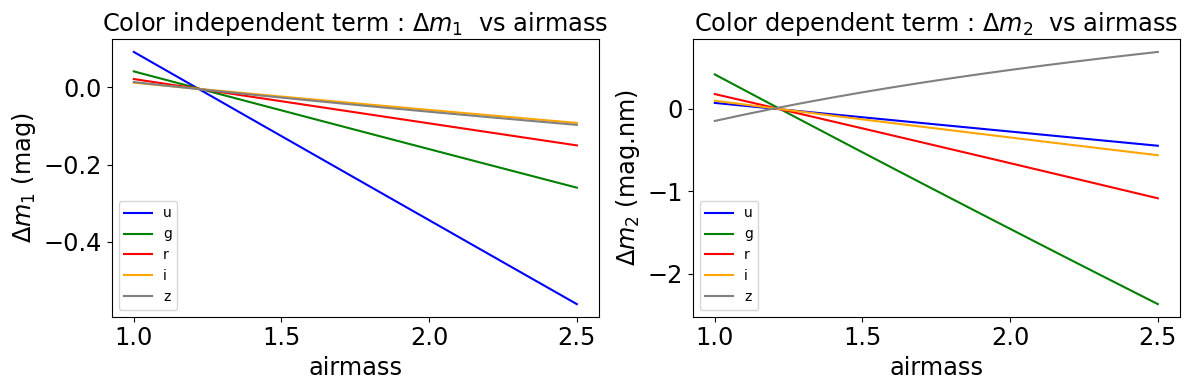

In [25]:
fig = plt.figure(figsize=(12,4))

# Figure 1
ax=fig.add_subplot(1,2,1)

Y = np.zeros(NAM)
for ifilt,f in enumerate(filter_tagnames):
    # loop on airmass
    for index_am,am in enumerate(all_am):
        the_II0_ratio = pc.coll_all_II0ratio_nonstd[index_am][f]
        
        Y[index_am] = 2.5*np.log10(the_II0_ratio)
    ax.plot(all_am,Y,'-',color=filter_color[ifilt],label=f)
ax.set_xlabel('airmass')
ax.set_ylabel('$\Delta m_1$ (mag)')
ax.set_title('Color independent term : $\Delta m_1$  vs airmass')
ax.legend()
          

# Figure 2
ax=fig.add_subplot(1,2,2)
Y = np.zeros(NAM)
for ifilt,f in enumerate(filter_tagnames):
    # loop on airmass
    for index_am,am in enumerate(all_am):
        the_II1_sub = pc.coll_all_II1sub_nonstd[index_am][f]
        Y[index_am] = the_II1_sub
    ax.plot(all_am,Y,'-',color=filter_color[ifilt],label=f)
ax.set_xlabel('airmass')
ax.set_ylabel('$\Delta m_2$ (mag.nm)')
ax.set_title('Color dependent term : $\Delta m_2$  vs airmass')
ax.legend()
plt.tight_layout()
plt.show()



- Left : Order 0 correction term in the different band.
The attenuation (in mag) with airmass is linear as expected from dominant scattering processes.
The attenuation slope with airmass is the largest in the blue filter, less in green less in red. But it is higher in $Y$ which is higher in $i$ which is larger in $z$.

- Right color corrections order 1 term that must be multiplied the SED relative shape slope in the band (in $nm^{-1}$ ). The hierarchy is different from the order 0 correction. The slope is higher in $G$ which is larger than in $U$ which is greater than in $Y$. It is less sensitive in $R,U,Z$ filters.

/var/folders/79/hrybm_4s0zjd4jsb7lp_trhh0000gp/T/ipykernel_4553/92947222.py:109: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


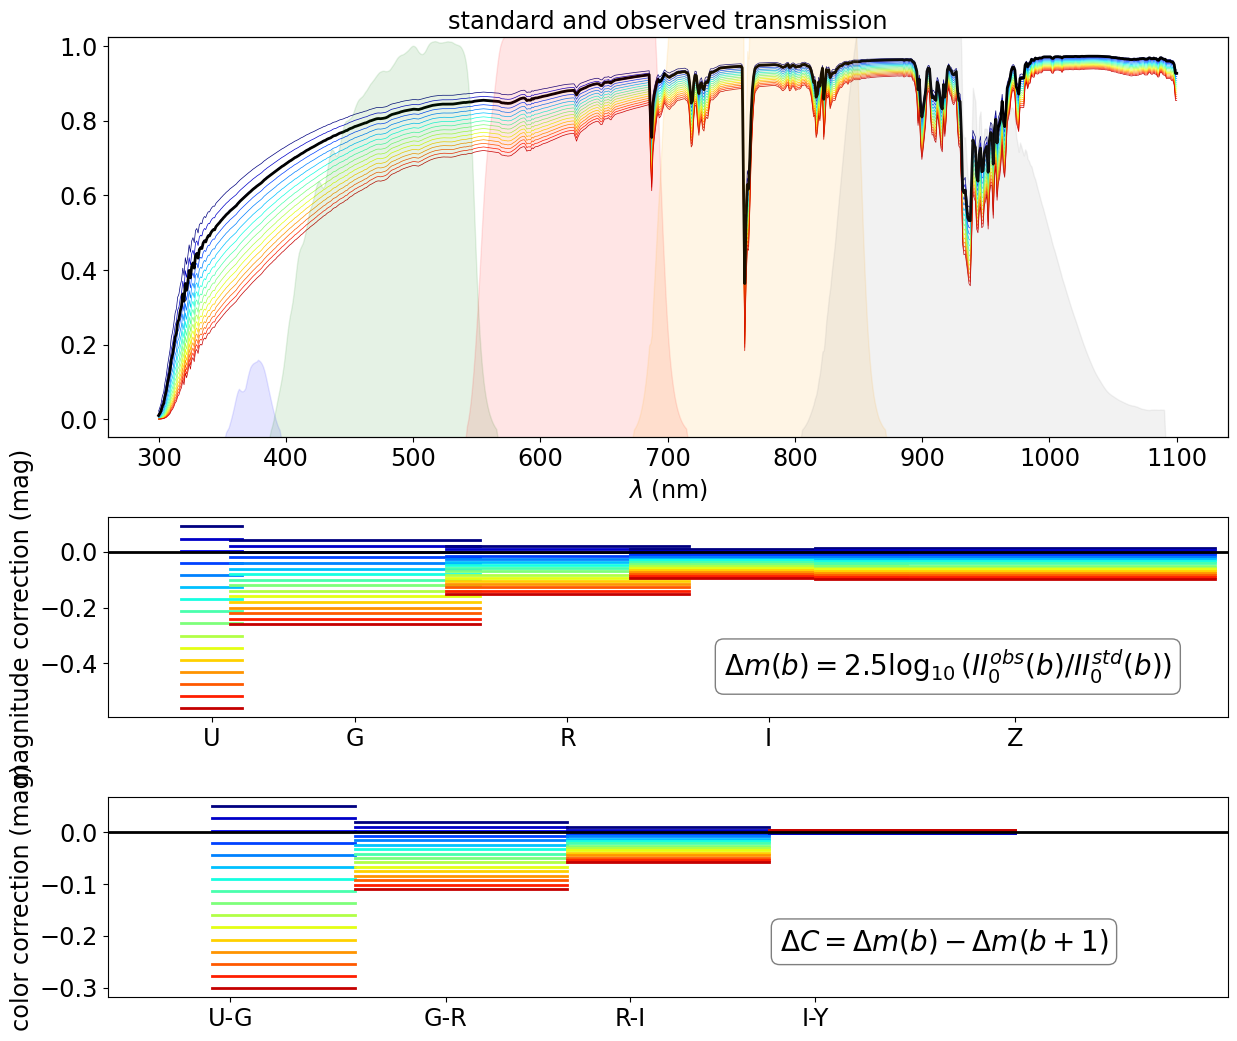

In [26]:
# wavelength bin colors
NOBS = len(all_am)

jet = plt.get_cmap('jet')
cNorm = colors.Normalize(vmin=0, vmax=NOBS)
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)
all_colors = scalarMap.to_rgba(np.arange(NOBS), alpha=1)


fig = plt.figure(figsize=(14,12))

gs = fig.add_gridspec(3, 1,  height_ratios=(3, 1.5, 1.5),
                      left=0.1, right=0.9, bottom=0.1, top=0.9,
                      wspace=0.05, hspace=0.3)
###############
#top figure
###############
axs = fig.add_subplot(gs[0, 0])

for idx_am,am in enumerate(all_am):
    atm  = pc.coll_atm_nonstd[idx_am]
   
    label = f"z={am:.1f}"
    
    axs.plot(WL,atm,color=all_colors[idx_am],label=label,lw=0.5)


axs.plot(pc.WL,pc.atm_std,color="k",lw=2,label="standard atmosphere")
#axs.legend(bbox_to_anchor=(1.03, 1.0))  
axs.set_xlabel("$\lambda$ (nm)")
axs.set_title("standard and observed transmission")

ax2 = axs.twinx()
for ifilt,f in enumerate(filter_tagnames):
    ax2.fill_between(pc.bandpass_total_std[f].wavelen,pc.bandpass_total_std[f].sb,color=filter_color[ifilt],alpha=0.1) 
    ax2.set_yticks([])    
    
ax2.set_ylim(0,0.5)

###################
#middle figure
#################

axs2 = fig.add_subplot(gs[1, 0])
# external loop on filters
for ifilt,f in enumerate(filter_tagnames):
    the_div_mag = np.zeros(NAM) # container
    # internal loop on airmass to get the difference on II
    for idx_am,am in enumerate(all_am):
        the_II0_ratio = pc.coll_all_II0ratio_nonstd[idx_am][f]
        
        the_div_mag[idx_am]= 2.5*np.log10(the_II0_ratio)
        
        xx= [FILTERWL[ifilt,0],FILTERWL[ifilt,1]]
        yy= [the_div_mag[idx_am],the_div_mag[idx_am]]
        axs2.plot(xx,yy,color=all_colors[idx_am],lw=2)
axs2.set_xlim(WLMIN,WLMAX)
axs2.axhline(y=0,lw=2,color="k")
axs2.set_xticks(FILTERWL[:,2])
axs2.set_xticklabels(Filter_tagnames, minor=False)
axs2.set_ylabel("magnitude correction (mag)")
#axs2.grid()
# these are matplotlib.patch.Patch properties
props = dict(boxstyle='round', facecolor='w', alpha=0.5)

textstr="$\Delta m(b) = 2.5 \log_{10} (II_0^{obs}(b)/II_0^{std}(b))$"
#axs2.set_title(textstr)
# place a text box in upper left in axes coords
axs2.text(0.55, 0.35, textstr, transform=axs2.transAxes, fontsize=20,
        verticalalignment='top', bbox=props)


###############################
# bottom figure
###############################
axs3 = fig.add_subplot(gs[2, 0])

for ifilt,f in enumerate(filter_tagnames):
    if ifilt == NFILT-1:
        break
    fnext = filter_tagnames[ifilt+1]
    
    the_div_mag = np.zeros(NAM)
    # loop on airmass to get the difference on II
    for idx_am,am in enumerate(all_am):
        the_II0_ratio1 = pc.coll_all_II0ratio_nonstd[idx_am][f]
        the_II0_ratio2 = pc.coll_all_II0ratio_nonstd[idx_am][fnext]
        
        dcolor = 2.5*np.log10( the_II0_ratio1)-2.5*np.log10(the_II0_ratio2)
        xx= [FILTERWL[ifilt,2],FILTERWL[ifilt+1,2]]
        yy= [dcolor,dcolor]
        axs3.plot(xx,yy,color=all_colors[idx_am],lw=2)
axs3.set_xlim(WLMIN,WLMAX)
axs3.axhline(y=0,lw=2,color="k")
#axs3.set_xlabel("$\lambda$ (nm)")

axs3.set_xticks(FILTERWL[1:,0])
axs3.set_xticklabels(Filtercolor_tagnames, minor=False)

axs3.set_ylabel("color correction (mag)")
#axs3.grid()
textstr="$\Delta C = \Delta m(b) - \Delta m(b+1)$"
#axs2.set_title(textstr)
# place a text box in upper left in axes coords
axs3.text(0.60, 0.35, textstr, transform=axs3.transAxes, fontsize=20,
        verticalalignment='top', bbox=props)


plt.tight_layout()    

- Top Figure : atmospheric attenuation with airmass.
- Middle figure : Order 0 magnitude correction to add to instrumental magnitudes
to account for an $obs$ airmass different from $std$ airmass.
Positive value along $y$ axis mean we need to decrease the measured flux, a negative value means we have to increase the measured flux.
The black line corresponds to an airmass = 1. Because it correspond to less airmass than the standard one, the observed magnitude must be slightly increased by 100 mmag in the U band.
On the contrary, taking the reddest line, the dark-red one correspond to a 2.5 airass. The atmosphere attenuate a lot. The magnitude mist be decreased by 600 mmag in the blue band.
This effect is less important other bands.

- Bottom figure : 
Extracted from the figure above the color correction we have to apply. 
Thus we compute the magnitude correction of the left bluer filter minus the magnitude correction for the right reddder filter.
A positive value in $y$ means we have to redden. A negative value in $y$ means we have to make bluer the color. 

## Variation of PWV

In [27]:
am = 1.2
oz = 300
tau= 0.04
beta = 1
all_pwv = np.arange(0,10,0.5)
NPWV = len(all_pwv)

In [28]:
pc.CalculateMultiObs(am,all_pwv,oz,tau,beta)

/Users/dagoret/MacOSX/GitHub/LSST/AtmosphericSimulation/rubinsimphot/src/rubinsimphot/phot_utils/bandpass.py:68: UserWarning: Wavelength sampling of 1.0 nm is > 0.2 nm, this may not work well with a Sed object. Consider resampling with resample_bandpass method.
  warnings.warn(


### PWV variation :  Observed filter and normalized response

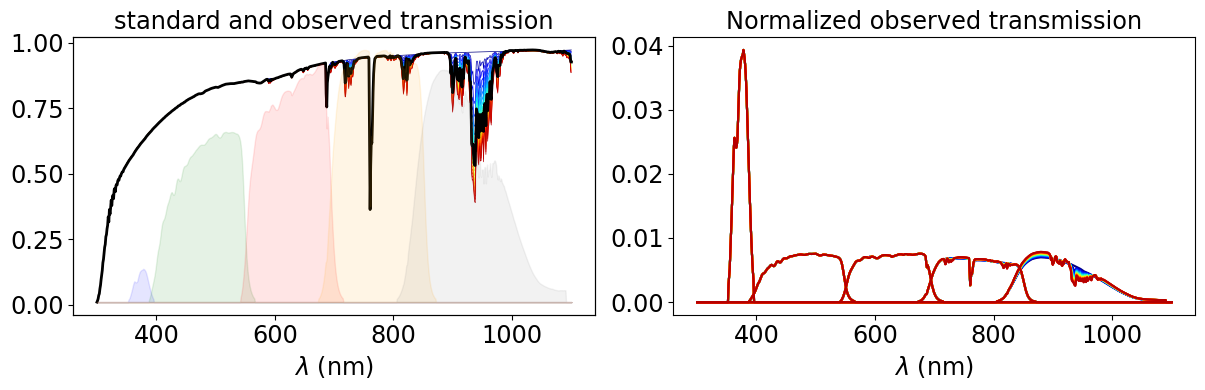

In [29]:
NOBS = len(all_pwv)

# wavelength bin colors
jet = plt.get_cmap('jet')
cNorm = colors.Normalize(vmin=0, vmax=NOBS)
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)
all_colors = scalarMap.to_rgba(np.arange(NOBS), alpha=1)


fig = plt.figure(figsize=(12,4))

# Figure 1
axs=fig.add_subplot(1,2,1)
for index,pwv in enumerate(all_pwv):
  
    atm = pc.coll_atm_nonstd[index]
    
    label = f"pwv={pwv:.1f}" 
    axs.plot(pc.WL,atm,color=all_colors[index],label=label,lw=0.5)
   
axs.plot(pc.WL,pc.atm_std,color="k",lw=2,label="standard atmosphere")
#axs.legend(bbox_to_anchor=(1.03, 1.0))  
axs.set_xlabel("$\lambda$ (nm)")
axs.set_title("standard and observed transmission")

ax2 = axs.twinx()
for ifilt,f in enumerate(filter_tagnames):
    ax2.fill_between(pc.bandpass_total_std[f].wavelen,pc.bandpass_total_std[f].sb,color=filter_color[ifilt],alpha=0.1) 
    ax2.set_yticks([])



# Figure 2
axs=fig.add_subplot(1,2,2)

all_linestyles = ['-','--','-.',':','-','--','-.',':','-','--','-.',':','-','--','-.',':']

# wavelength bin colors
jet = plt.get_cmap('jet')
cNorm = colors.Normalize(vmin=0, vmax=NOBS)
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)
all_colors = scalarMap.to_rgba(np.arange(NOBS), alpha=1)


for idx_pwv,pwv in enumerate(all_pwv):
    
    
    label = f"pwv={pwv:.1f}"
    
    for ifilt,f in enumerate(filter_tagnames):
        
        the_x=pc.WL
        the_y=pc.coll_phiArray_nonstd[idx_pwv][ifilt,:]
       
        
        if ifilt==1:
            axs.plot(the_x,the_y,color=all_colors[idx_pwv],linestyle="-",label=label )
        else:
            axs.plot(the_x,the_y,color=all_colors[idx_pwv],linestyle="-")

axs.set_xlabel("$\lambda$ (nm)")
axs.set_title("Normalized observed transmission")
#axs.legend(bbox_to_anchor=(1.03, 1.0))  


plt.tight_layout()
plt.show()



- we see on the same figure the two kinds of photometric corrections.
- Left : the atmospheric attenuation in each band : We see $pwv$ attenuation in $Y$, $Z$ and $I$ band.

- Right : normalized response distorsion used in the the color correction. As expected distorsion of the normalised are the largest in $Y$. Slight effect are seen in $Z,I$.

/var/folders/79/hrybm_4s0zjd4jsb7lp_trhh0000gp/T/ipykernel_4553/4034327539.py:42: RuntimeWarning: invalid value encountered in divide
  the_ratio = the_y/the_y_std


Text(0.5, 1.0, 'Relative observed/standard normalized transmission')

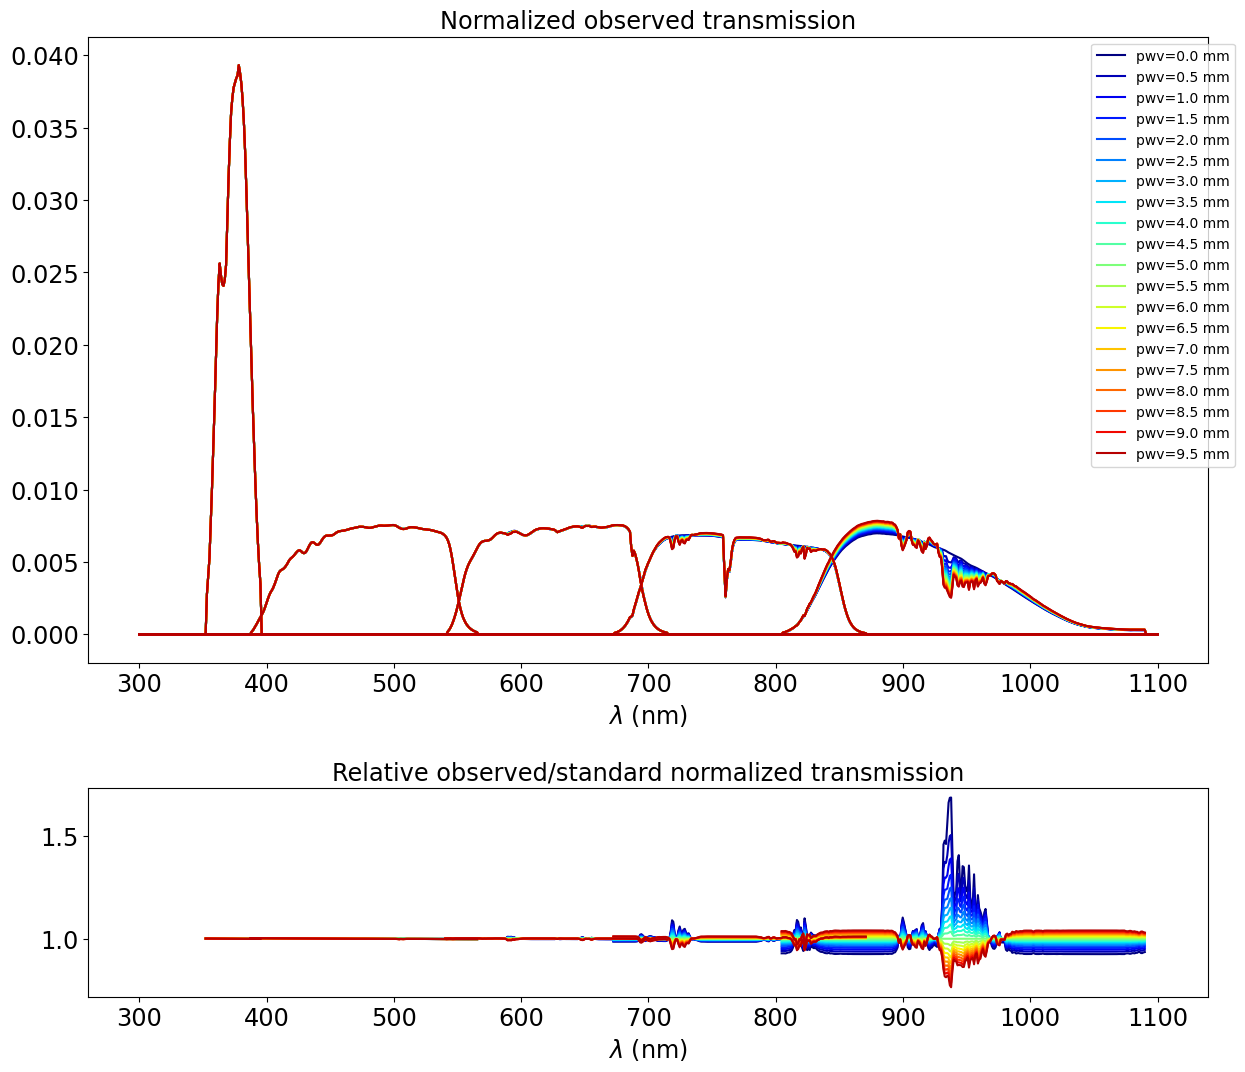

In [30]:
fig = plt.figure(figsize=(14,12))

gs = fig.add_gridspec(2, 1,  height_ratios=(3, 1),
                      left=0.1, right=0.9, bottom=0.1, top=0.9,
                      wspace=0.05, hspace=0.3)


axs = fig.add_subplot(gs[0, 0])

for idx_pwv,pwv in enumerate(all_pwv):
       
    label = f"pwv={pwv:.1f} mm"
    
    for ifilt,f in enumerate(filter_tagnames):
        
        the_x=pc.WL
        the_y=pc.coll_phiArray_nonstd[idx_pwv][ifilt,:]
        the_y_std = pc.phiArray_std[ifilt:,]
       
        
        if ifilt==1:
            axs.plot(the_x,the_y,color=all_colors[idx_pwv],linestyle="-",label=label )
        else:
            axs.plot(the_x,the_y,color=all_colors[idx_pwv],linestyle="-")

axs.set_xlabel("$\lambda$ (nm)")
axs.set_title("Normalized observed transmission")
axs.legend(bbox_to_anchor=(1.03, 1.0)) 
main_ax = axs

axs = fig.add_subplot(gs[1, 0],sharex=main_ax)

for idx_pwv,pwv in enumerate(all_pwv):
       
    label = f"pwv={pwv:.1f} mm"
    
    for ifilt,f in enumerate(filter_tagnames):
        
        the_x=pc.WL
        the_y=pc.coll_phiArray_nonstd[idx_pwv][ifilt,:]
        the_y_std = pc.phiArray_std[ifilt,:]
        the_ratio = the_y/the_y_std
       
        
        if ifilt==1:
            axs.plot(the_x,the_ratio,color=all_colors[idx_pwv],linestyle="-",label=label )
        else:
            axs.plot(the_x,the_ratio,color=all_colors[idx_pwv],linestyle="-")

axs.set_xlabel("$\lambda$ (nm)")
axs.set_title("Relative observed/standard normalized transmission")
#axs.legend(bbox_to_anchor=(1.03, 1.0)) 


- Obviously there is a large impact of PWV in Y band. 

### Zero point for PWV variation

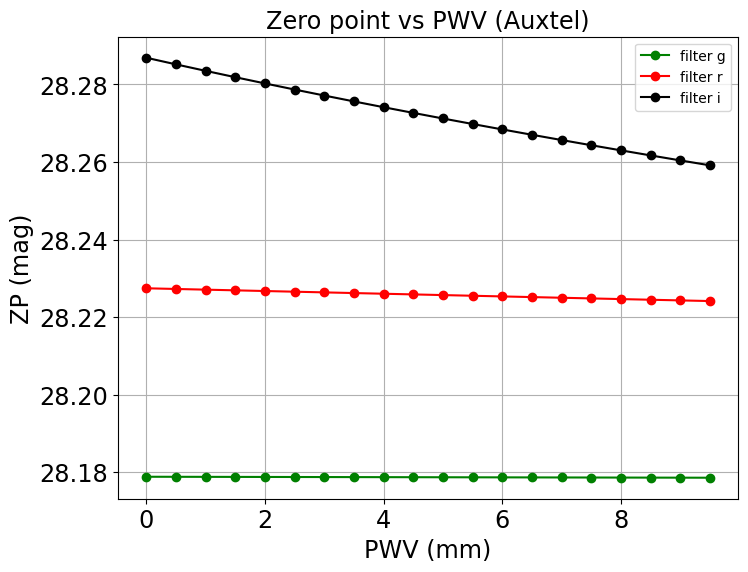

In [31]:
fig, ax = plt.subplots(1,1,figsize=(8,6))
ax.plot(all_pwv,pc.allcollperfilter['g']['ZPT_nonstd'],'o-g',label="filter g")
ax.plot(all_pwv,pc.allcollperfilter['r']['ZPT_nonstd'],'o-r',label="filter r")
ax.plot(all_pwv,pc.allcollperfilter['i']['ZPT_nonstd'],'o-k',label="filter i")
ax.set_title("Zero point vs PWV (Auxtel)")
ax.set_xlabel("PWV (mm)")
ax.set_ylabel("ZP (mag)")
ax.legend()
ax.grid()

### PWV variation : $2.5 \log_{10} (II_0^{obs}(b)/II_0^{std}(b))$ and  $II_{1}^{std}(b)-II_{1}^{obs}(b)$

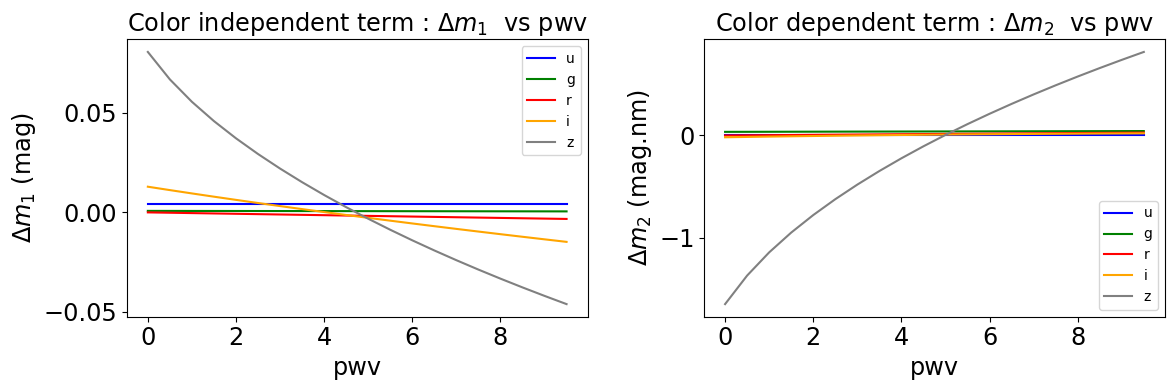

In [32]:
fig = plt.figure(figsize=(12,4))

# Figure 1
ax=fig.add_subplot(1,2,1)

Y = np.zeros(NPWV)
for ifilt,f in enumerate(filter_tagnames):
    # loop on airmass
    for index_pwv,pwv in enumerate(all_pwv):
        the_II0_ratio = pc.coll_all_II0ratio_nonstd[index_pwv][f]
        
        Y[index_pwv] = 2.5*np.log10(the_II0_ratio)
    ax.plot(all_pwv,Y,'-',color=filter_color[ifilt],label=f)
ax.set_xlabel('pwv')
ax.set_ylabel('$\Delta m_1$ (mag)')
ax.set_title('Color independent term : $\Delta m_1$  vs pwv')
ax.legend()
          

# Figure 2
ax=fig.add_subplot(1,2,2)
Y = np.zeros(NPWV)
for ifilt,f in enumerate(filter_tagnames):
    # loop on airmass
    for index_pwv,pwv in enumerate(all_pwv):
        the_II1_sub = pc.coll_all_II1sub_nonstd[index_pwv][f]
        Y[index_pwv] = the_II1_sub
    ax.plot(all_pwv,Y,'-',color=filter_color[ifilt],label=f)
ax.set_xlabel('pwv')
ax.set_ylabel('$\Delta m_2$ (mag.nm)')
ax.set_title('Color dependent term : $\Delta m_2$  vs pwv')
ax.legend()
plt.tight_layout()
plt.show()



- Left : Order 0 correction term in the different band.
The attenuation (in mag) with pwv is dominant in $Y$ with small effect in $Z$ and $I$. The curve is not a straight line. It is exected because absorption by PWV is not linear.


- Right color corrections order 1 term that must be multiplied the SED relative shape slope in the band (in $nm^{-1}$ ). The hierarchy is different from the order 0 correction. The slope is higher in $Y$ which is larger than in $Z$. No residual color effect is observable in other filters. 
The color correction effect has similar order of magnitude in $Y$ than the color effect when varying pwv.

/var/folders/79/hrybm_4s0zjd4jsb7lp_trhh0000gp/T/ipykernel_4553/2358006418.py:109: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


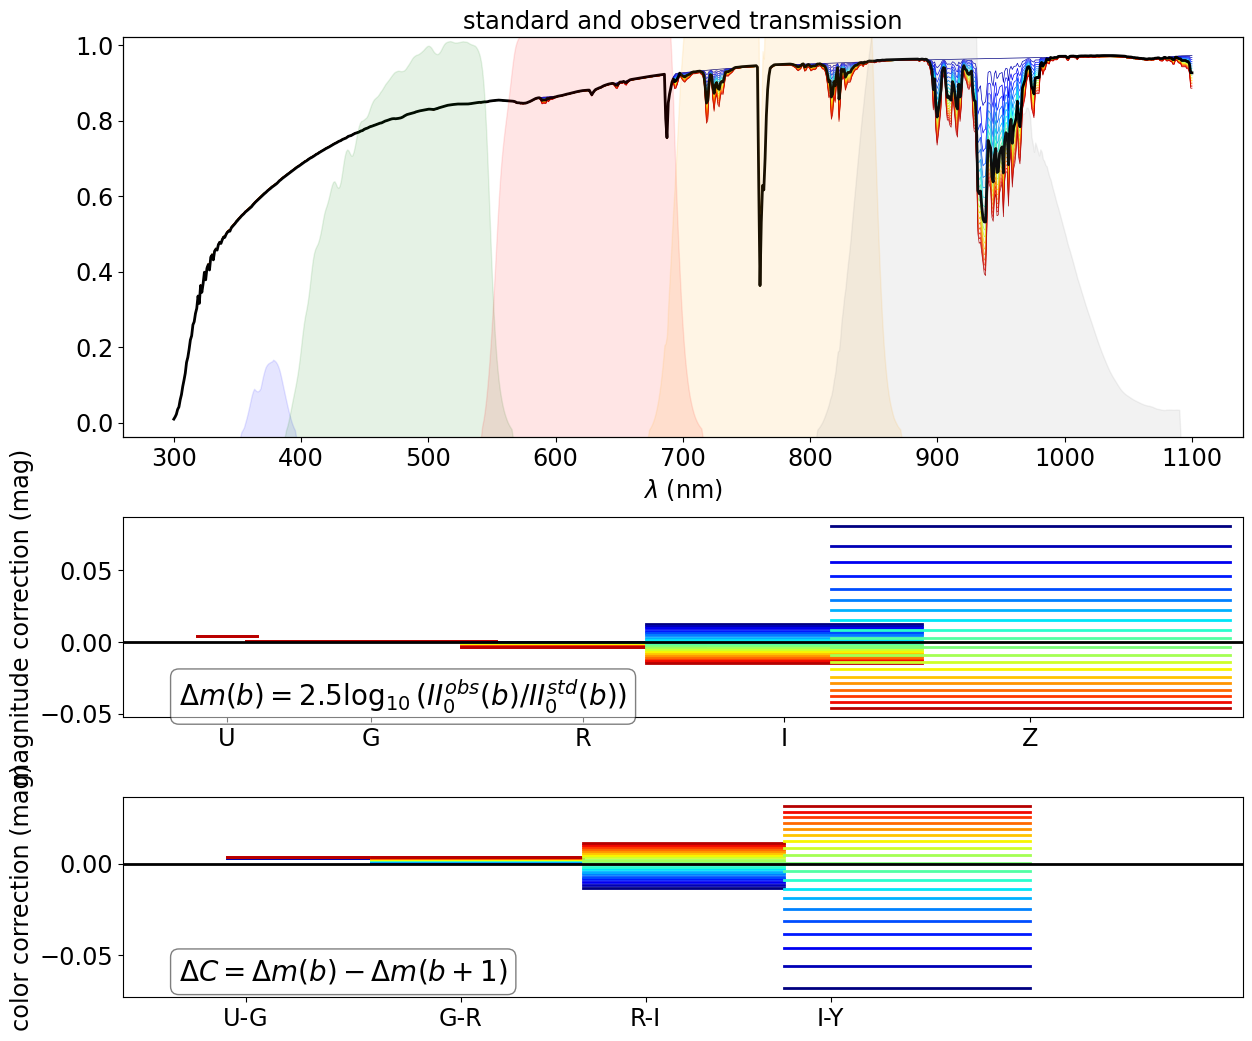

In [33]:
# wavelength bin colors
NOBS = len(all_pwv)

jet = plt.get_cmap('jet')
cNorm = colors.Normalize(vmin=0, vmax=NOBS)
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)
all_colors = scalarMap.to_rgba(np.arange(NOBS), alpha=1)


fig = plt.figure(figsize=(14,12))

gs = fig.add_gridspec(3, 1,  height_ratios=(3, 1.5, 1.5),
                      left=0.1, right=0.9, bottom=0.1, top=0.9,
                      wspace=0.05, hspace=0.3)
###############
#top figure
###############
axs = fig.add_subplot(gs[0, 0])

for idx_pwv,pwv in enumerate(all_pwv):
    atm  = pc.coll_atm_nonstd[idx_pwv]
   
    label = f"pwv={pwv:.1f}"
    
    axs.plot(WL,atm,color=all_colors[idx_pwv],label=label,lw=0.5)


axs.plot(pc.WL,pc.atm_std,color="k",lw=2,label="standard atmosphere")
#axs.legend(bbox_to_anchor=(1.03, 1.0))  
axs.set_xlabel("$\lambda$ (nm)")
axs.set_title("standard and observed transmission")

ax2 = axs.twinx()
for ifilt,f in enumerate(filter_tagnames):
    ax2.fill_between(pc.bandpass_total_std[f].wavelen,pc.bandpass_total_std[f].sb,color=filter_color[ifilt],alpha=0.1) 
    ax2.set_yticks([])    
    
ax2.set_ylim(0,0.5)

###################
#middle figure
#################

axs2 = fig.add_subplot(gs[1, 0])
# external loop on filters
for ifilt,f in enumerate(filter_tagnames):
    the_div_mag = np.zeros(NPWV) # container
    # internal loop on airmass to get the difference on II
    for idx_pwv,pwv in enumerate(all_pwv):
        the_II0_ratio = pc.coll_all_II0ratio_nonstd[idx_pwv][f]
        the_div_mag[idx_pwv]= 2.5*np.log10(the_II0_ratio)
        xx= [FILTERWL[ifilt,0],FILTERWL[ifilt,1]]
        yy= [the_div_mag[idx_pwv],the_div_mag[idx_pwv]]
        axs2.plot(xx,yy,color=all_colors[idx_pwv],lw=2)
axs2.set_xlim(WLMIN,WLMAX)
axs2.axhline(y=0,lw=2,color="k")
axs2.set_xticks(FILTERWL[:,2])
axs2.set_xticklabels(Filter_tagnames, minor=False)
axs2.set_ylabel("magnitude correction (mag)")
#axs2.grid()
# these are matplotlib.patch.Patch properties
props = dict(boxstyle='round', facecolor='w', alpha=0.5)

textstr="$\Delta m(b) = 2.5 \log_{10} (II_0^{obs}(b)/II_0^{std}(b))$"
#axs2.set_title(textstr)
# place a text box in upper left in axes coords
#axs2.text(0.55, 0.35, textstr, transform=axs2.transAxes, fontsize=20,
#        verticalalignment='top', bbox=props)
axs2.text(0.05, 0.2, textstr, transform=axs2.transAxes, fontsize=20,
        verticalalignment='top', bbox=props)

###############################
# bottom figure
###############################
axs3 = fig.add_subplot(gs[2, 0])

for ifilt,f in enumerate(filter_tagnames):
    if ifilt == NFILT-1:
        break
    fnext = filter_tagnames[ifilt+1]
    
    the_div_mag = np.zeros(NPWV)
    # loop on pwv to get the difference on II
    for idx_pwv,pwv in enumerate(all_pwv):
        the_II0_ratio1 = pc.coll_all_II0ratio_nonstd[idx_pwv][f]
        the_II0_ratio2 = pc.coll_all_II0ratio_nonstd[idx_pwv][fnext]
        
        dcolor = 2.5*np.log10( the_II0_ratio1)-2.5*np.log10(the_II0_ratio2)
        xx= [FILTERWL[ifilt,2],FILTERWL[ifilt+1,2]]
        yy= [dcolor,dcolor]
        axs3.plot(xx,yy,color=all_colors[idx_pwv],lw=2)
axs3.set_xlim(WLMIN,WLMAX)
axs3.axhline(y=0,lw=2,color="k")
#axs3.set_xlabel("$\lambda$ (nm)")

axs3.set_xticks(FILTERWL[1:,0])
axs3.set_xticklabels(Filtercolor_tagnames, minor=False)

axs3.set_ylabel("color correction (mag)")
#axs3.grid()
textstr="$\Delta C = \Delta m(b) - \Delta m(b+1)$"
#axs2.set_title(textstr)
# place a text box in upper left in axes coords
#axs3.text(0.60, 0.35, textstr, transform=axs3.transAxes, fontsize=20,
#        verticalalignment='top', bbox=props)
axs3.text(0.05, 0.2, textstr, transform=axs3.transAxes, fontsize=20,
        verticalalignment='top', bbox=props)

plt.tight_layout()    

- Top Figure : atmospheric attenuation with PWV.

- Middle figure : Order 0 magnitude correction to add to instrumental magnitudes
to account for an $obs$ PWV different from $std$ PWV. Positive value along $y$ axis mean we need to decrease the measured flux, a negative value means we have to increase the measured flux.
The black line corresponds to pwv = 0 mm. Because it corresponds to less attenuation than the standard one, the observed magnitude must be slightly increased by 200 mmag in the Y band.
On the contrary, taking the reddest line, the dark-red one correspond to a PWV = 9.5 mm. The atmosphere attenuate a lot. The magnitude must be decreased by 100 mmag in the Y band. This effect is less important other bands.

- Bottom figure : 
Extracted from the figure above the color correction we have to apply. 
Thus we compute the magnitude correction of the left bluer filter minus the magnitude correction for the right reddder filter.
A positive value in $y$ means we have to redden. A negative value in $y$ means we have to make bluer the color. The effect of a larger attenuation in $Y$ filter wrt $Z$ filter leads to making the observed SED bluer. Then the correction must redden the color (50 mmag) for Z-Y for pwv = 9.5 mm

### Required accuracy on PWV

- for $x = pwv$ and $y = \Delta m$

$$
y = f(x)
$$

then

$$
\sigma_x < \frac{1}{\left| \frac{dy}{dx} \right|} \sigma_y
$$

Text(0.5, 0.98, 'Required accuracy on PWV in z band')

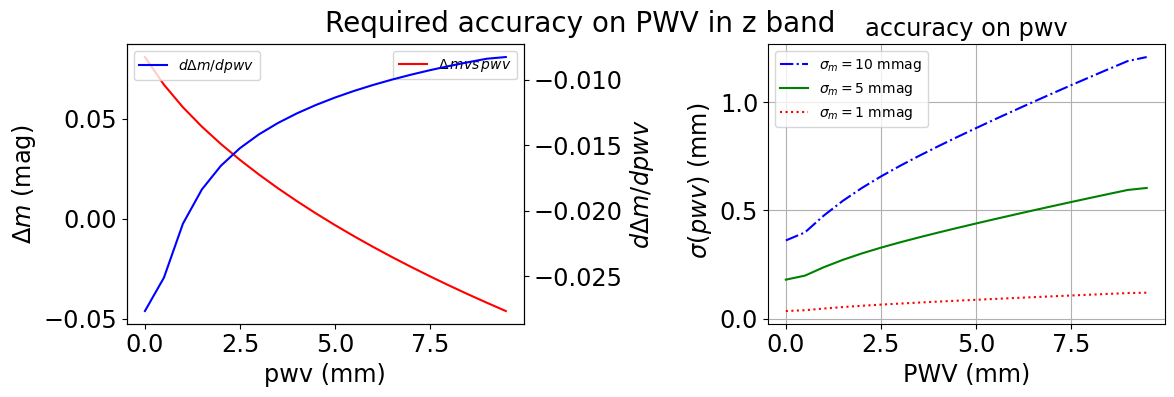

In [34]:
# Select filter
f_sel = 'z'
fig = plt.figure(figsize=(12,4))
ax = fig.add_subplot(1,2,1)
x = pc.allparameters
y = 2.5*np.log10(pc.allcollperfilter[f_sel]['II0ratio_nonstd'])
ax.set_xlabel("pwv")
ax.set_ylabel("$\Delta m_1$")

ax.plot(x,y,'r-',label = "$\Delta \, m vs \,pwv$")
ax.set_xlabel("pwv (mm)")
ax.set_ylabel("$\Delta m$ (mag)")

ax2 = ax.twinx()
ax2.plot(x,np.gradient(y,x),'b-',label="$d\Delta m/ d pwv$")
ax2.set_ylabel("$d\Delta m/ d pwv$")
ax.legend(loc="best")
ax2.legend(loc="best")

ax = fig.add_subplot(1,2,2)
ax.plot(x,np.abs(1/np.gradient(y,x))*0.01,'b-.',label="$\sigma_m = 10$ mmag")
ax.plot(x,np.abs(1/np.gradient(y,x))*0.005,'g-',label="$\sigma_m = 5$ mmag")
ax.plot(x,np.abs(1/np.gradient(y,x))*0.001,'r:',label="$\sigma_m = 1$ mmag")
ax.legend()
ax.set_title("accuracy on pwv")
ax.set_xlabel("PWV (mm)")
ax.set_ylabel(" $\sigma(pwv)$ (mm)")
ax.grid()
plt.tight_layout()
plt.suptitle(f"Required accuracy on PWV in {f_sel} band",fontsize=20)

- Left : in filter $Y$, $\Delta m$ vs $pwv$ (red curve)
- Right : required accuracy in PWV vs PWV for 3 resolution on the magnitude correction.

## Ozone variation

In [35]:
am = 1.2
oz = 300
pwv= 5
tau= 0.04
beta = 1.0
all_oz = np.arange(0,600,50)
NOZ = len(all_oz)

In [36]:
pc.CalculateMultiObs(am,pwv,all_oz,tau,beta)

/Users/dagoret/MacOSX/GitHub/LSST/AtmosphericSimulation/rubinsimphot/src/rubinsimphot/phot_utils/bandpass.py:68: UserWarning: Wavelength sampling of 1.0 nm is > 0.2 nm, this may not work well with a Sed object. Consider resampling with resample_bandpass method.
  warnings.warn(


### Ozone variation :  Observed filter and normalized response

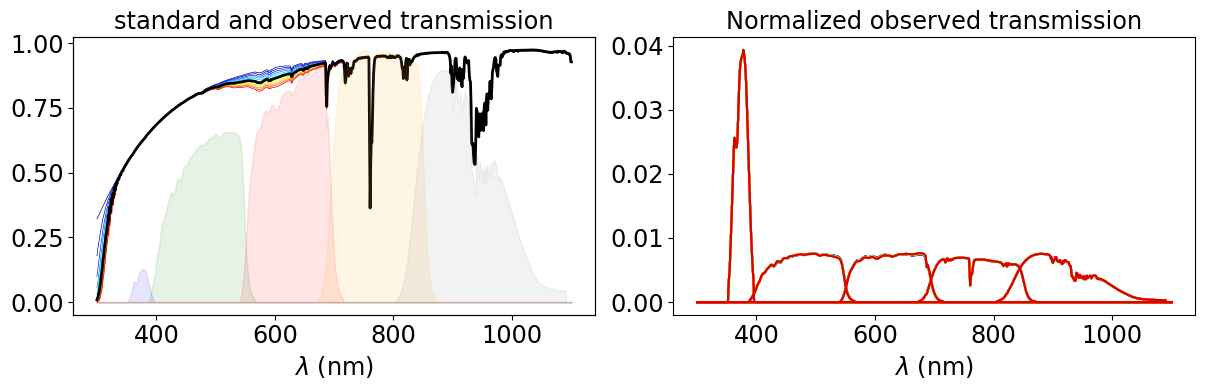

In [37]:
NOBS = len(all_oz)

# wavelength bin colors
jet = plt.get_cmap('jet')
cNorm = colors.Normalize(vmin=0, vmax=NOBS)
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)
all_colors = scalarMap.to_rgba(np.arange(NOBS), alpha=1)


fig = plt.figure(figsize=(12,4))

# Figure 1
axs=fig.add_subplot(1,2,1)
for index,oz in enumerate(all_oz):
  
    atm = pc.coll_atm_nonstd[index]
    
    label = f"oz={oz:.0f}" 
    axs.plot(pc.WL,atm,color=all_colors[index],label=label,lw=0.5)
   
axs.plot(pc.WL,pc.atm_std,color="k",lw=2,label="standard atmosphere")
#axs.legend(bbox_to_anchor=(1.03, 1.0))  
axs.set_xlabel("$\lambda$ (nm)")
axs.set_title("standard and observed transmission")

ax2 = axs.twinx()
for ifilt,f in enumerate(filter_tagnames):
    ax2.fill_between(pc.bandpass_total_std[f].wavelen,pc.bandpass_total_std[f].sb,color=filter_color[ifilt],alpha=0.1) 
    ax2.set_yticks([])



# Figure 2
axs=fig.add_subplot(1,2,2)

all_linestyles = ['-','--','-.',':','-','--','-.',':','-','--','-.',':','-','--','-.',':']

# wavelength bin colors
jet = plt.get_cmap('jet')
cNorm = colors.Normalize(vmin=0, vmax=NOBS)
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)
all_colors = scalarMap.to_rgba(np.arange(NOBS), alpha=1)


for idx_oz,oz in enumerate(all_oz):
    
    
    label = f"oz={oz:.0f}"
    
    for ifilt,f in enumerate(filter_tagnames):
        
        the_x=pc.WL
        the_y=pc.coll_phiArray_nonstd[idx_oz][ifilt,:]
       
        
        if ifilt==1:
            axs.plot(the_x,the_y,color=all_colors[idx_oz],linestyle="-",label=label )
        else:
            axs.plot(the_x,the_y,color=all_colors[idx_oz],linestyle="-")

axs.set_xlabel("$\lambda$ (nm)")
axs.set_title("Normalized observed transmission")
#axs.legend(bbox_to_anchor=(1.03, 1.0))  


plt.tight_layout()
plt.show()



- we see on the same figure the two kinds of photometric corrections.
- Left : the atmospheric attenuation in each band : We see ozone presents attnenation mostly in $R$ filter and slightly in $G$ filter.


- Right : normalized response distorsion used in the the color correction. Distortions of thenoramised function look tiny in filter $R$ and $G$.


/var/folders/79/hrybm_4s0zjd4jsb7lp_trhh0000gp/T/ipykernel_4553/508467822.py:52: RuntimeWarning: invalid value encountered in divide
  the_ratio = the_y/the_y_std


(0.95, 1.05)

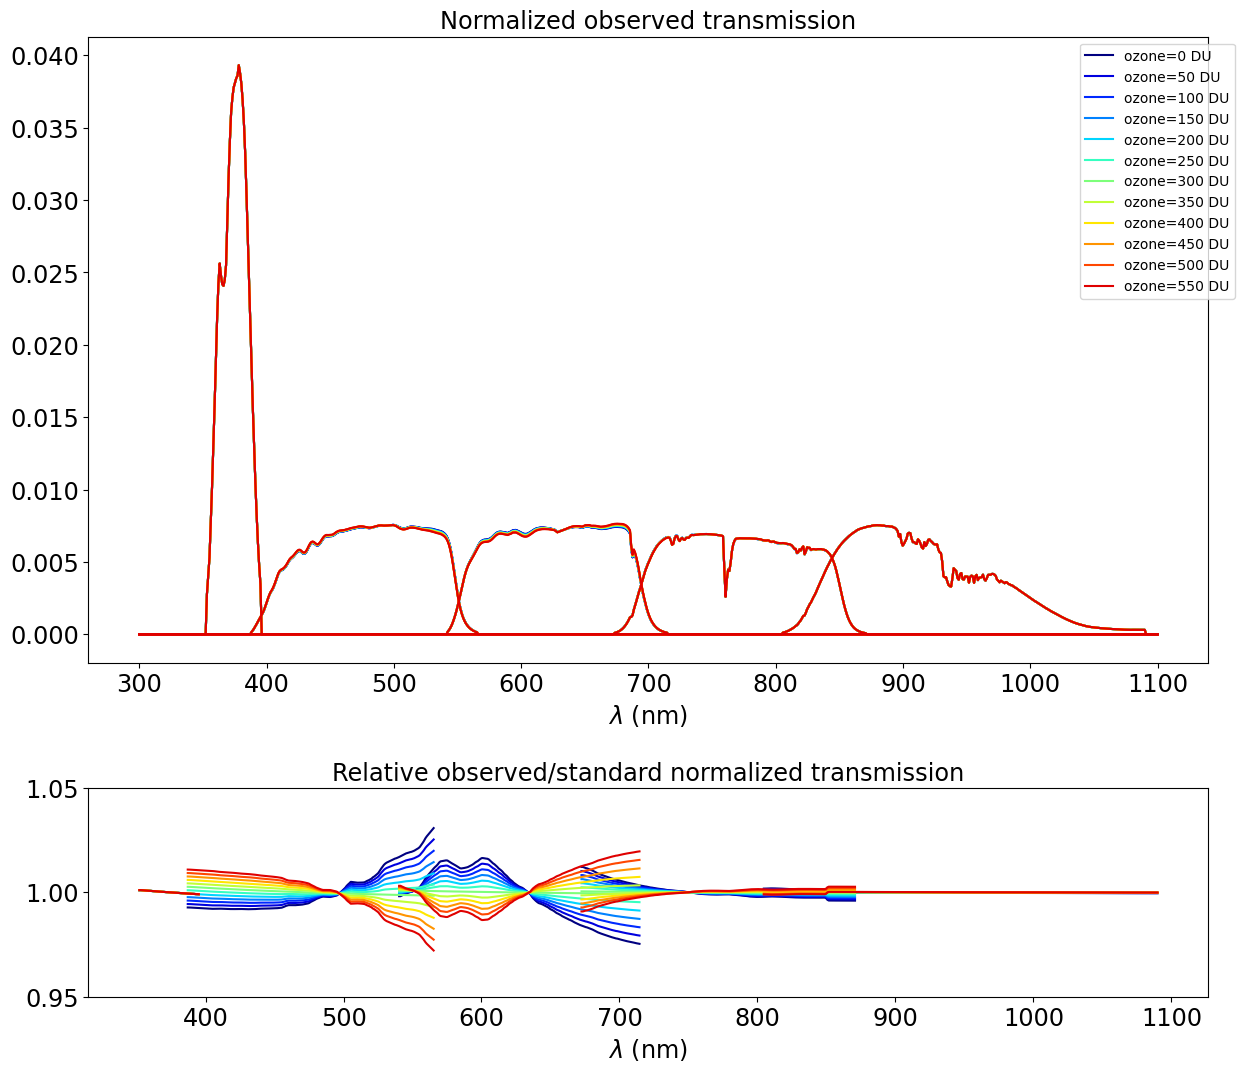

In [38]:
all_linestyles = ['-','--','-.',':','-','--','-.',':','-','--','-.',':','-','--','-.',':']

# wavelength bin colors
jet = plt.get_cmap('jet')
cNorm = colors.Normalize(vmin=0, vmax=NOBS)
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)
all_colors = scalarMap.to_rgba(np.arange(NOBS), alpha=1)



fig = plt.figure(figsize=(14,12))

gs = fig.add_gridspec(2, 1,  height_ratios=(3, 1),
                      left=0.1, right=0.9, bottom=0.1, top=0.9,
                      wspace=0.05, hspace=0.3)


axs = fig.add_subplot(gs[0, 0])

for idx_oz,oz in enumerate(all_oz):
       
    label = f"ozone={oz:.0f} DU"
    
    for ifilt,f in enumerate(filter_tagnames):
        
        the_x=pc.WL
        the_y=pc.coll_phiArray_nonstd[idx_oz][ifilt,:]
        the_y_std = pc.phiArray_std[ifilt:,]
       
        
        if ifilt==1:
            axs.plot(the_x,the_y,color=all_colors[idx_oz],linestyle="-",label=label )
        else:
            axs.plot(the_x,the_y,color=all_colors[idx_oz],linestyle="-")

axs.set_xlabel("$\lambda$ (nm)")
axs.set_title("Normalized observed transmission")
axs.legend(bbox_to_anchor=(1.03, 1.0)) 


axs = fig.add_subplot(gs[1, 0])

for idx_oz,oz in enumerate(all_oz):
       
    label = f"ozone={oz:.1f} DU"
    
    for ifilt,f in enumerate(filter_tagnames):
        
        the_x=pc.WL
        the_y=pc.coll_phiArray_nonstd[idx_oz][ifilt,:]
        the_y_std = pc.phiArray_std[ifilt,:]
        the_ratio = the_y/the_y_std
       
        
        if ifilt==1:
            axs.plot(the_x,the_ratio,color=all_colors[idx_oz],linestyle="-",label=label )
        else:
            axs.plot(the_x,the_ratio,color=all_colors[idx_oz],linestyle="-")

axs.set_xlabel("$\lambda$ (nm)")
axs.set_title("Relative observed/standard normalized transmission")
axs.set_ylim(0.95,1.05)
#axs.legend(bbox_to_anchor=(1.03, 1.0)) 


Note the Blue filter is affected by the UV cutoff.
However the  Ozone color effect is of the order of 1% or less.


### Zero point for Ozone variation

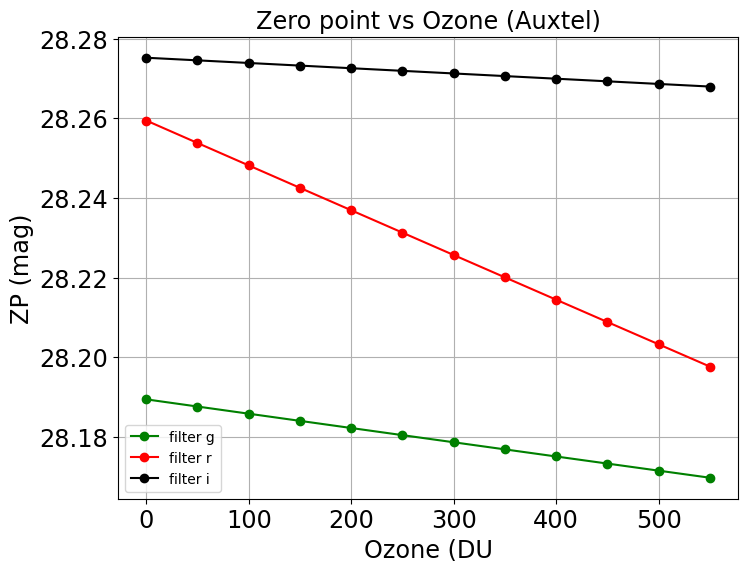

In [39]:
fig, ax = plt.subplots(1,1,figsize=(8,6))
ax.plot(all_oz,pc.allcollperfilter['g']['ZPT_nonstd'],'o-g',label="filter g")
ax.plot(all_oz,pc.allcollperfilter['r']['ZPT_nonstd'],'o-r',label="filter r")
ax.plot(all_oz,pc.allcollperfilter['i']['ZPT_nonstd'],'o-k',label="filter i")
ax.set_title("Zero point vs Ozone (Auxtel)")
ax.set_xlabel("Ozone (DU")
ax.set_ylabel("ZP (mag)")
ax.legend()
ax.grid()

### Ozone variation : $2.5 \log_{10} (II_0^{obs}(b)/II_0^{std}(b))$ and  $II_{1}^{std}(b)-II_{1}^{obs}(b)$

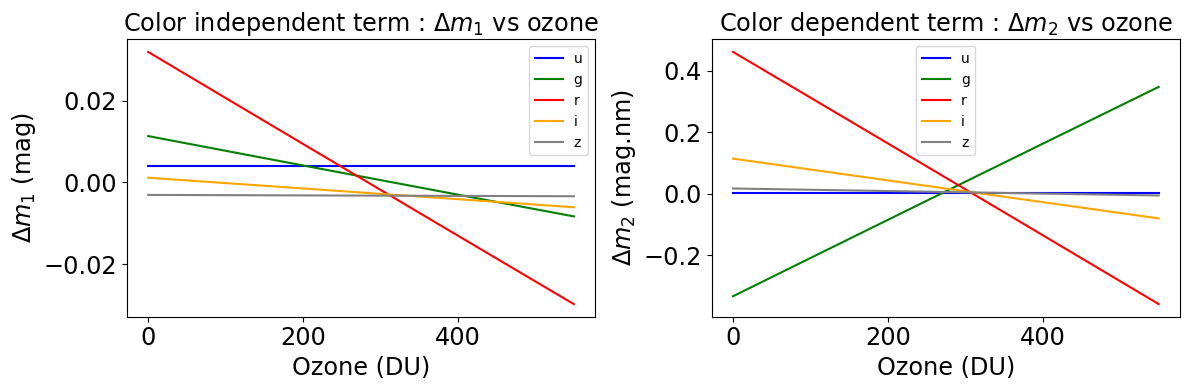

In [40]:
fig = plt.figure(figsize=(12,4))

# Figure 1
ax=fig.add_subplot(1,2,1)

Y = np.zeros(NOZ)
for ifilt,f in enumerate(filter_tagnames):
    # loop on airmass
    for index_oz,oz in enumerate(all_oz):
        the_II0_ratio = pc.coll_all_II0ratio_nonstd[index_oz][f]
        
        Y[index_oz] = 2.5*np.log10(the_II0_ratio)
    ax.plot(all_oz,Y,'-',color=filter_color[ifilt],label=f)
ax.set_xlabel('Ozone (DU)')
ax.set_ylabel('$\Delta m_1$ (mag)')
ax.set_title('Color independent term : $\Delta m_1$ vs ozone')
ax.legend()
          

# Figure 2
ax=fig.add_subplot(1,2,2)
Y = np.zeros(NOZ)
for ifilt,f in enumerate(filter_tagnames):
    # loop on ozone
    for index_oz,oz in enumerate(all_oz):
        the_II1_sub = pc.coll_all_II1sub_nonstd[index_oz][f]
        Y[index_oz] = the_II1_sub
    ax.plot(all_oz,Y,'-',color=filter_color[ifilt],label=f)
ax.set_xlabel('Ozone (DU)')
ax.set_ylabel('$\Delta m_2$ (mag.nm)')
ax.set_title('Color dependent term : $\Delta m_2$ vs ozone')
ax.legend()
plt.tight_layout()
plt.show()



- Left : Order 0 correction term in the different band.
The attenuation (in mag) with ozone is dominant in $R$ . The curve is a straight line indicating a non saturated absorption line


- Right color corrections order 1 term that must be multiplied the SED relative shape slope in the band (in $nm^{-1}$ ). This correction effect is one order of magnitude less than that for PWV or airmass.

/var/folders/79/hrybm_4s0zjd4jsb7lp_trhh0000gp/T/ipykernel_4553/3187000498.py:111: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


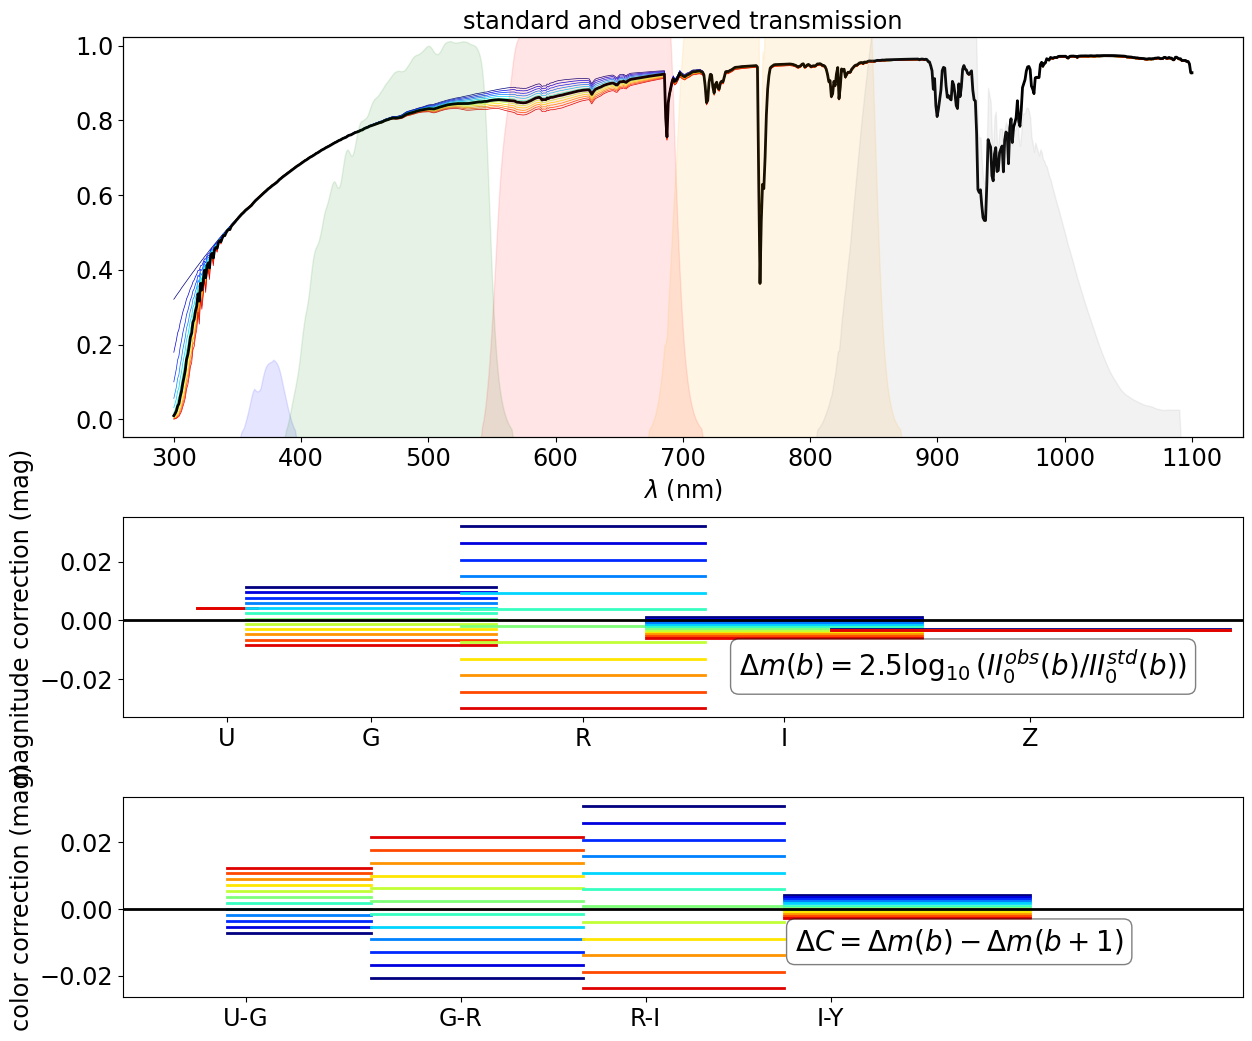

In [41]:
# wavelength bin colors
NOBS = len(all_oz)

jet = plt.get_cmap('jet')
cNorm = colors.Normalize(vmin=0, vmax=NOBS)
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)
all_colors = scalarMap.to_rgba(np.arange(NOBS), alpha=1)


fig = plt.figure(figsize=(14,12))

gs = fig.add_gridspec(3, 1,  height_ratios=(3, 1.5, 1.5),
                      left=0.1, right=0.9, bottom=0.1, top=0.9,
                      wspace=0.05, hspace=0.3)
###############
#top figure
###############
axs = fig.add_subplot(gs[0, 0])

for idx_oz,oz in enumerate(all_oz):
    atm  = pc.coll_atm_nonstd[idx_oz]
   
    label = f"pwv={oz:.0f}"
    
    axs.plot(WL,atm,color=all_colors[idx_oz],label=label,lw=0.5)


axs.plot(pc.WL,pc.atm_std,color="k",lw=2,label="standard atmosphere")
#axs.legend(bbox_to_anchor=(1.03, 1.0))  
axs.set_xlabel("$\lambda$ (nm)")
axs.set_title("standard and observed transmission")

ax2 = axs.twinx()
for ifilt,f in enumerate(filter_tagnames):
    ax2.fill_between(pc.bandpass_total_std[f].wavelen,pc.bandpass_total_std[f].sb,color=filter_color[ifilt],alpha=0.1) 
    ax2.set_yticks([])    
    
ax2.set_ylim(0,0.5)

###################
#middle figure
#################

axs2 = fig.add_subplot(gs[1, 0])
# external loop on filters
for ifilt,f in enumerate(filter_tagnames):
    the_div_mag = np.zeros(NOZ) # container
    # internal loop on ozone to get the difference on II
    for idx_oz,oz in enumerate(all_oz):
        the_II0_ratio = pc.coll_all_II0ratio_nonstd[idx_oz][f]
        
        the_div_mag[idx_oz]= 2.5*np.log10(the_II0_ratio)
        
        xx= [FILTERWL[ifilt,0],FILTERWL[ifilt,1]]
        yy= [the_div_mag[idx_oz],the_div_mag[idx_oz]]
        axs2.plot(xx,yy,color=all_colors[idx_oz],lw=2)
axs2.set_xlim(WLMIN,WLMAX)
axs2.axhline(y=0,lw=2,color="k")
axs2.set_xticks(FILTERWL[:,2])
axs2.set_xticklabels(Filter_tagnames, minor=False)
axs2.set_ylabel("magnitude correction (mag)")
#axs2.grid()
# these are matplotlib.patch.Patch properties
props = dict(boxstyle='round', facecolor='w', alpha=0.5)

textstr="$\Delta m(b) = 2.5 \log_{10} (II_0^{obs}(b)/II_0^{std}(b))$"
#axs2.set_title(textstr)
# place a text box in upper left in axes coords
axs2.text(0.55, 0.35, textstr, transform=axs2.transAxes, fontsize=20,
        verticalalignment='top', bbox=props)
#axs2.text(0.05, 0.2, textstr, transform=axs2.transAxes, fontsize=20,
#        verticalalignment='top', bbox=props)

###############################
# bottom figure
###############################
axs3 = fig.add_subplot(gs[2, 0])

for ifilt,f in enumerate(filter_tagnames):
    if ifilt == NFILT-1:
        break
    fnext = filter_tagnames[ifilt+1]
    
    the_div_mag = np.zeros(NOZ)
    # loop on pwv to get the difference on II
    for idx_oz,oz in enumerate(all_oz):
        the_II0_ratio1 = pc.coll_all_II0ratio_nonstd[idx_oz][f]
        the_II0_ratio2 = pc.coll_all_II0ratio_nonstd[idx_oz][fnext]
        
        dcolor = 2.5*np.log10( the_II0_ratio1)-2.5*np.log10(the_II0_ratio2)
        xx= [FILTERWL[ifilt,2],FILTERWL[ifilt+1,2]]
        yy= [dcolor,dcolor]
        axs3.plot(xx,yy,color=all_colors[idx_oz],lw=2)
axs3.set_xlim(WLMIN,WLMAX)
axs3.axhline(y=0,lw=2,color="k")
#axs3.set_xlabel("$\lambda$ (nm)")

axs3.set_xticks(FILTERWL[1:,0])
axs3.set_xticklabels(Filtercolor_tagnames, minor=False)

axs3.set_ylabel("color correction (mag)")
#axs3.grid()
textstr="$\Delta C = \Delta m(b) - \Delta m(b+1)$"
#axs2.set_title(textstr)
# place a text box in upper left in axes coords
axs3.text(0.60, 0.35, textstr, transform=axs3.transAxes, fontsize=20,
        verticalalignment='top', bbox=props)
#axs3.text(0.05, 0.2, textstr, transform=axs3.transAxes, fontsize=20,
#        verticalalignment='top', bbox=props)

plt.tight_layout()    

- Top Figure : atmospheric attenuation with Ozone.

- Middle figure : Order 0 magnitude correction to add to instrumental magnitudes
to account for an $obs$ Ozone different from $std$ Ozone. Positive value along $y$ axis mean we need to decrease the measured flux, a negative value means we have to increase the measured flux.
In the R filter, the dark blue line corresponds to ozone = 0 DU. Because it corresponds to less attenuation than the standard one, the observed magnitude must be slightly increased by 30 mmag in the R band.
On the contrary, taking the reddest line, the dark-red one correspond to a ozone = 600 DU. The atmosphere attenuates slightly. The magnitude must be decreased by 30 mmag in the R band. This effect is less important other bands.

- Bottom figure : 
Extracted from the figure above the color correction we have to apply. 
Thus we compute the magnitude correction of the left bluer filter minus the magnitude correction for the right reddder filter.
A positive value in $y$ means we have to redden. A negative value in $y$ means we have to make bluer the color. The colors correction is significative in G-R and R-I up to a maximum effect of +/- 25 mmag.


### Required accuracy on Ozone

Text(0.5, 0.98, 'Required accuracy on Ozone in r band')

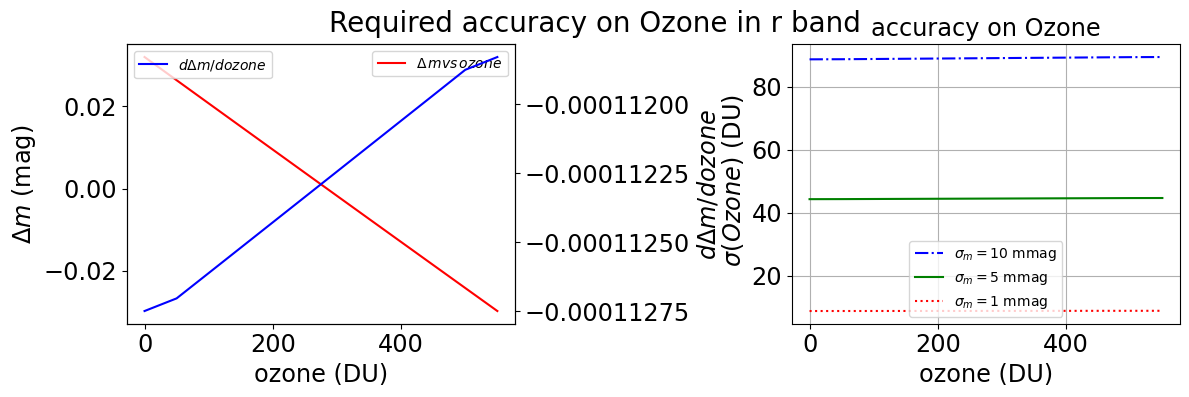

In [42]:
# Select filter
f_sel = 'r'
fig = plt.figure(figsize=(12,4))
ax = fig.add_subplot(1,2,1)
x = pc.allparameters
y = 2.5*np.log10(pc.allcollperfilter[f_sel]['II0ratio_nonstd'])
ax.set_xlabel("ozone")
ax.set_ylabel("$\Delta m_1$")

ax.plot(x,y,'r-',label = "$\Delta \, m vs \, ozone$")
ax.set_xlabel("ozone (DU)")
ax.set_ylabel("$\Delta m$ (mag)")

ax2 = ax.twinx()
ax2.plot(x,np.gradient(y,x),'b-',label="$d\Delta m/ d ozone$")
ax2.set_ylabel("$d\Delta m/ d ozone$")
ax.legend(loc="best")
ax2.legend(loc="best")

ax = fig.add_subplot(1,2,2)
ax.plot(x,np.abs(1/np.gradient(y,x))*0.01,'b-.',label="$\sigma_m = 10$ mmag")
ax.plot(x,np.abs(1/np.gradient(y,x))*0.005,'g-',label="$\sigma_m = 5$ mmag")
ax.plot(x,np.abs(1/np.gradient(y,x))*0.001,'r:',label="$\sigma_m = 1$ mmag")
ax.legend()
ax.set_title("accuracy on Ozone")
ax.set_xlabel("ozone (DU)")
ax.set_ylabel(" $\sigma(Ozone)$ (DU)")
ax.grid()
plt.tight_layout()
plt.suptitle(f"Required accuracy on Ozone in {f_sel} band",fontsize="20")

The required acuracy on Ozone is 40 DU for a 5 mmag on the magnitude

## Aerosol variation

In [43]:
am = 1.2
oz = 300
pwv= 5
tau= 0.04
beta = 1.0
all_taus = np.arange(0,0.1,0.01)
NTAU = len(all_taus)

In [44]:
pc.CalculateMultiObs(am,pwv,oz,all_taus,beta)

/Users/dagoret/MacOSX/GitHub/LSST/AtmosphericSimulation/rubinsimphot/src/rubinsimphot/phot_utils/bandpass.py:68: UserWarning: Wavelength sampling of 1.0 nm is > 0.2 nm, this may not work well with a Sed object. Consider resampling with resample_bandpass method.
  warnings.warn(


### VAOD variation :  Observed filter and normalized response

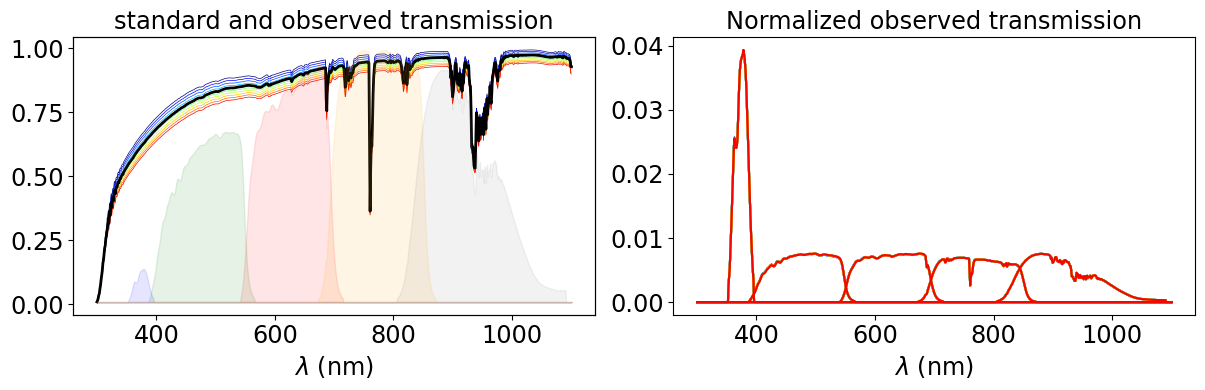

In [45]:
NOBS = len(all_taus)

# wavelength bin colors
jet = plt.get_cmap('jet')
cNorm = colors.Normalize(vmin=0, vmax=NOBS)
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)
all_colors = scalarMap.to_rgba(np.arange(NOBS), alpha=1)


fig = plt.figure(figsize=(12,4))

# Figure 1
axs=fig.add_subplot(1,2,1)
for index,tau in enumerate(all_taus):
  
    atm = pc.coll_atm_nonstd[index]
    
    label = f"tau={tau:.2f}" 
    axs.plot(pc.WL,atm,color=all_colors[index],label=label,lw=0.5)
   
axs.plot(pc.WL,pc.atm_std,color="k",lw=2,label="standard atmosphere")
#axs.legend(bbox_to_anchor=(1.03, 1.0))  
axs.set_xlabel("$\lambda$ (nm)")
axs.set_title("standard and observed transmission")

ax2 = axs.twinx()
for ifilt,f in enumerate(filter_tagnames):
    ax2.fill_between(pc.bandpass_total_std[f].wavelen,pc.bandpass_total_std[f].sb,color=filter_color[ifilt],alpha=0.1) 
    ax2.set_yticks([])



# Figure 2
axs=fig.add_subplot(1,2,2)

all_linestyles = ['-','--','-.',':','-','--','-.',':','-','--','-.',':','-','--','-.',':']

# wavelength bin colors
jet = plt.get_cmap('jet')
cNorm = colors.Normalize(vmin=0, vmax=NOBS)
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)
all_colors = scalarMap.to_rgba(np.arange(NOBS), alpha=1)


for idx_tau,tau in enumerate(all_taus):
    
    
    label = f"pwv={tau:.2f}"
    
    for ifilt,f in enumerate(filter_tagnames):
        
        the_x=pc.WL
        the_y=pc.coll_phiArray_nonstd[idx_tau][ifilt,:]
       
        
        if ifilt==1:
            axs.plot(the_x,the_y,color=all_colors[idx_tau],linestyle="-",label=label )
        else:
            axs.plot(the_x,the_y,color=all_colors[idx_tau],linestyle="-")

axs.set_xlabel("$\lambda$ (nm)")
axs.set_title("Normalized observed transmission")
#axs.legend(bbox_to_anchor=(1.03, 1.0))  


plt.tight_layout()
plt.show()



- we see on the same figure the two kinds of photometric corrections.
- Left : the atmospheric attenuation in each band : 

- Right : normalized response distorsion used in the the color correction. Distortions of the normalised function doesn't show distorsions.

/var/folders/79/hrybm_4s0zjd4jsb7lp_trhh0000gp/T/ipykernel_4553/1377341277.py:52: RuntimeWarning: invalid value encountered in divide
  the_ratio = the_y/the_y_std


Text(0.5, 1.0, 'Relative observed/standard normalized transmission')

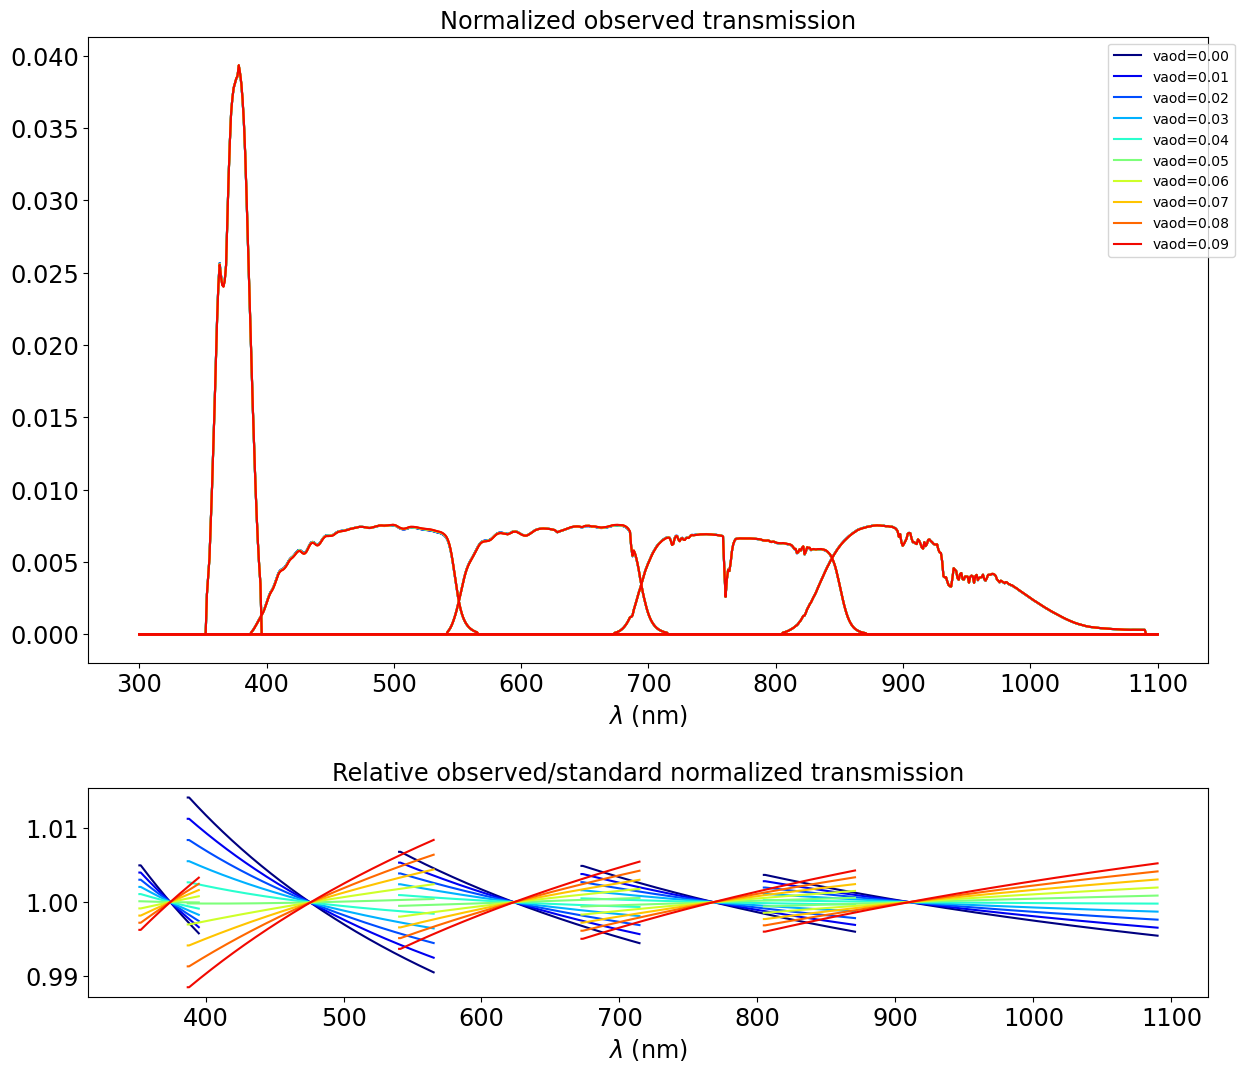

In [46]:
all_linestyles = ['-','--','-.',':','-','--','-.',':','-','--','-.',':','-','--','-.',':']

# wavelength bin colors
jet = plt.get_cmap('jet')
cNorm = colors.Normalize(vmin=0, vmax=NOBS)
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)
all_colors = scalarMap.to_rgba(np.arange(NOBS), alpha=1)



fig = plt.figure(figsize=(14,12))

gs = fig.add_gridspec(2, 1,  height_ratios=(3, 1),
                      left=0.1, right=0.9, bottom=0.1, top=0.9,
                      wspace=0.05, hspace=0.3)


axs = fig.add_subplot(gs[0, 0])

for idx_vaod,vaod in enumerate(all_taus):
       
    label = f"vaod={vaod:.2f}"
    
    for ifilt,f in enumerate(filter_tagnames):
        
        the_x=pc.WL
        the_y=pc.coll_phiArray_nonstd[idx_vaod][ifilt,:]
        the_y_std = pc.phiArray_std[ifilt:,]
       
        
        if ifilt==1:
            axs.plot(the_x,the_y,color=all_colors[idx_vaod],linestyle="-",label=label )
        else:
            axs.plot(the_x,the_y,color=all_colors[idx_vaod],linestyle="-")

axs.set_xlabel("$\lambda$ (nm)")
axs.set_title("Normalized observed transmission")
axs.legend(bbox_to_anchor=(1.03, 1.0)) 


axs = fig.add_subplot(gs[1, 0])

for idx_vaod,vaod in enumerate(all_taus):
       
    label = f"vaod={vaod:.2f}"
    
    for ifilt,f in enumerate(filter_tagnames):
        
        the_x=pc.WL
        the_y=pc.coll_phiArray_nonstd[idx_vaod][ifilt,:]
        the_y_std = pc.phiArray_std[ifilt,:]
        the_ratio = the_y/the_y_std
       
        
        if ifilt==1:
            axs.plot(the_x,the_ratio,color=all_colors[idx_vaod],linestyle="-",label=label )
        else:
            axs.plot(the_x,the_ratio,color=all_colors[idx_vaod],linestyle="-")

axs.set_xlabel("$\lambda$ (nm)")
axs.set_title("Relative observed/standard normalized transmission")
#axs.legend(bbox_to_anchor=(1.03, 1.0)) 


- Distortion of normalized response is less than 1%.

### Zero point for VAOD variation

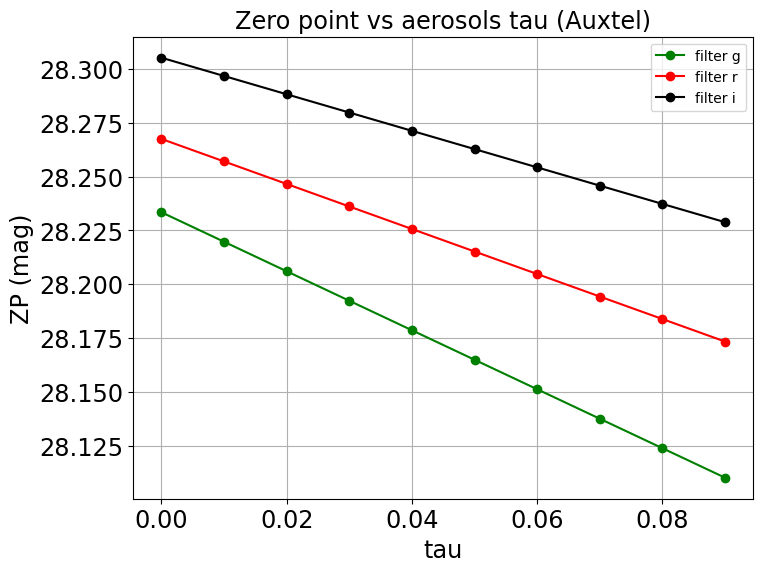

In [47]:
fig, ax = plt.subplots(1,1,figsize=(8,6))
ax.plot(all_taus,pc.allcollperfilter['g']['ZPT_nonstd'],'o-g',label="filter g")
ax.plot(all_taus,pc.allcollperfilter['r']['ZPT_nonstd'],'o-r',label="filter r")
ax.plot(all_taus,pc.allcollperfilter['i']['ZPT_nonstd'],'o-k',label="filter i")
ax.set_title("Zero point vs aerosols tau (Auxtel)")
ax.set_xlabel("tau")
ax.set_ylabel("ZP (mag)")
ax.legend()
ax.grid()

### VAOD variation : $2.5 \log_{10} (II_0^{obs}(b)/II_0^{std}(b))$ and  $II_{1}^{std}(b)-II_{1}^{obs}(b)$

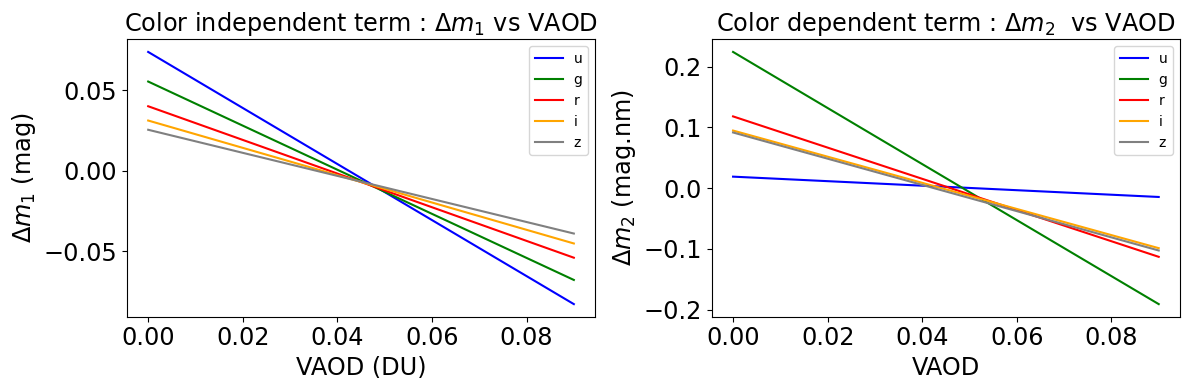

In [48]:
fig = plt.figure(figsize=(12,4))

# Figure 1
ax=fig.add_subplot(1,2,1)

Y = np.zeros(NTAU)
for ifilt,f in enumerate(filter_tagnames):
    # loop on airmass
    for index_aer,aer in enumerate(all_taus):
        the_II0_ratio = pc.coll_all_II0ratio_nonstd[index_aer][f]
        
        Y[index_aer] = 2.5*np.log10(the_II0_ratio)
    ax.plot(all_taus,Y,'-',color=filter_color[ifilt],label=f)
ax.set_xlabel('VAOD (DU)')
ax.set_ylabel('$\Delta m_1$ (mag)')
ax.set_title('Color independent term : $\Delta m_1$ vs VAOD')
ax.legend()
          

# Figure 2
ax=fig.add_subplot(1,2,2)
Y = np.zeros(NTAU)
for ifilt,f in enumerate(filter_tagnames):
    # loop on vaod
    for index_aer,aer in enumerate(all_taus):
        the_II1_sub = pc.coll_all_II1sub_nonstd[index_aer][f]
        Y[index_aer] = the_II1_sub
    ax.plot(all_taus,Y,'-',color=filter_color[ifilt],label=f)
ax.set_xlabel('VAOD')
ax.set_ylabel('$\Delta m_2$ (mag.nm)')
ax.set_title('Color dependent term : $\Delta m_2$  vs VAOD')
ax.legend()
plt.tight_layout()
plt.show()



- Left : Order 0 correction term in the different band.
The attenuation (in mag) with ozone is dominant in $B$ . The curves are straight line indicating a scattering attenuation.


- Right color corrections order 1 term that must be multiplied the SED relative shape slope in the band (in $nm^{-1}$ ). This correction effect is one order of magnitude less than that for PWV or airmass.

/var/folders/79/hrybm_4s0zjd4jsb7lp_trhh0000gp/T/ipykernel_4553/3084202052.py:109: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


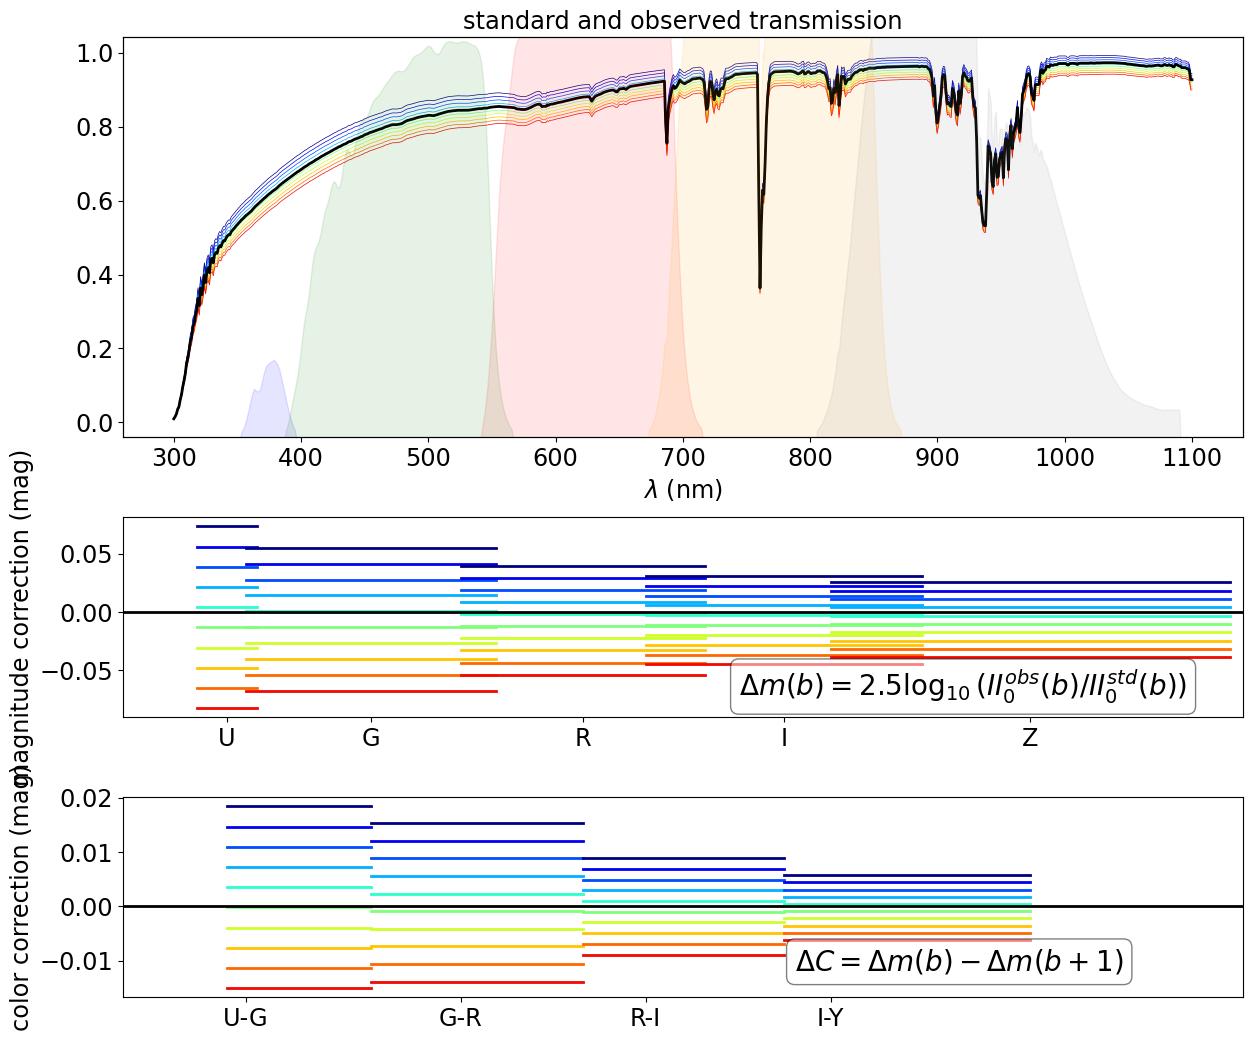

In [49]:
# wavelength bin colors
NOBS = len(all_taus)

jet = plt.get_cmap('jet')
cNorm = colors.Normalize(vmin=0, vmax=NOBS)
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)
all_colors = scalarMap.to_rgba(np.arange(NOBS), alpha=1)


fig = plt.figure(figsize=(14,12))

gs = fig.add_gridspec(3, 1,  height_ratios=(3, 1.5, 1.5),
                      left=0.1, right=0.9, bottom=0.1, top=0.9,
                      wspace=0.05, hspace=0.3)
###############
#top figure
###############
axs = fig.add_subplot(gs[0, 0])

for idx_aer,aer in enumerate(all_taus):
    atm  = pc.coll_atm_nonstd[idx_aer]
   
    label = f"aer={aer:.2f}"
    
    axs.plot(WL,atm,color=all_colors[idx_aer],label=label,lw=0.5)


axs.plot(pc.WL,pc.atm_std,color="k",lw=2,label="standard atmosphere")
#axs.legend(bbox_to_anchor=(1.03, 1.0))  
axs.set_xlabel("$\lambda$ (nm)")
axs.set_title("standard and observed transmission")

ax2 = axs.twinx()
for ifilt,f in enumerate(filter_tagnames):
    ax2.fill_between(pc.bandpass_total_std[f].wavelen,pc.bandpass_total_std[f].sb,color=filter_color[ifilt],alpha=0.1) 
    ax2.set_yticks([])    
    
ax2.set_ylim(0,0.5)

###################
#middle figure
#################

axs2 = fig.add_subplot(gs[1, 0])
# external loop on filters
for ifilt,f in enumerate(filter_tagnames):
    the_div_mag = np.zeros(NTAU) # container
    # internal loop on ozone to get the difference on II
    for idx_aer,aer in enumerate(all_taus):
        the_II0_ratio = pc.coll_all_II0ratio_nonstd[idx_aer][f]
        the_div_mag[idx_aer]= 2.5*np.log10(the_II0_ratio)
        xx= [FILTERWL[ifilt,0],FILTERWL[ifilt,1]]
        yy= [the_div_mag[idx_aer],the_div_mag[idx_aer]]
        axs2.plot(xx,yy,color=all_colors[idx_aer],lw=2)
axs2.set_xlim(WLMIN,WLMAX)
axs2.axhline(y=0,lw=2,color="k")
axs2.set_xticks(FILTERWL[:,2])
axs2.set_xticklabels(Filter_tagnames, minor=False)
axs2.set_ylabel("magnitude correction (mag)")
#axs2.grid()
# these are matplotlib.patch.Patch properties
props = dict(boxstyle='round', facecolor='w', alpha=0.5)

textstr="$\Delta m(b) = 2.5 \log_{10} (II_0^{obs}(b)/II_0^{std}(b))$"
#axs2.set_title(textstr)
# place a text box in upper left in axes coords
axs2.text(0.55, 0.25, textstr, transform=axs2.transAxes, fontsize=20,
        verticalalignment='top', bbox=props)
#axs2.text(0.05, 0.2, textstr, transform=axs2.transAxes, fontsize=20,
#        verticalalignment='top', bbox=props)

###############################
# bottom figure
###############################
axs3 = fig.add_subplot(gs[2, 0])

for ifilt,f in enumerate(filter_tagnames):
    if ifilt == NFILT-1:
        break
    fnext = filter_tagnames[ifilt+1]
    
    the_div_mag = np.zeros(NTAU)
    # loop on pwv to get the difference on II
    for idx_aer,aer in enumerate(all_taus):
        the_II0_ratio1 = pc.coll_all_II0ratio_nonstd[idx_aer][f]
        the_II0_ratio2 = pc.coll_all_II0ratio_nonstd[idx_aer][fnext]
        
        dcolor = 2.5*np.log10( the_II0_ratio1)-2.5*np.log10(the_II0_ratio2)
        xx= [FILTERWL[ifilt,2],FILTERWL[ifilt+1,2]]
        yy= [dcolor,dcolor]
        axs3.plot(xx,yy,color=all_colors[idx_aer],lw=2)
axs3.set_xlim(WLMIN,WLMAX)
axs3.axhline(y=0,lw=2,color="k")
#axs3.set_xlabel("$\lambda$ (nm)")

axs3.set_xticks(FILTERWL[1:,0])
axs3.set_xticklabels(Filtercolor_tagnames, minor=False)

axs3.set_ylabel("color correction (mag)")
#axs3.grid()
textstr="$\Delta C = \Delta m(b) - \Delta m(b+1)$"
#axs2.set_title(textstr)
# place a text box in upper left in axes coords
axs3.text(0.60, 0.25, textstr, transform=axs3.transAxes, fontsize=20,
        verticalalignment='top', bbox=props)
#axs3.text(0.05, 0.2, textstr, transform=axs3.transAxes, fontsize=20,
#        verticalalignment='top', bbox=props)

plt.tight_layout()    

- Top Figure : atmospheric attenuation with VAOD.

- Middle figure : Order 0 magnitude correction to add to instrumental magnitudes
to account for an $obs$ VAOD different from $std$ VAOD. Positive value along $y$ axis mean we need to decrease the measured flux, a negative value means we have to increase the measured flux.
In the B filter, the dark blue line corresponds to VAOD = 0. Because it corresponds to less attenuation than the standard one, the observed magnitude must be slightly increased by 80 mmag.
On the contrary, taking the reddest line, the dark-red one correspond to a VAOD = 10%. The atmosphere attenuates. The magnitude must be decreased by 100 mmag in the B band. This effect is less important other bands.

- Bottom figure : 
Extracted from the figure above the color correction we have to apply. 
Thus we compute the magnitude correction of the left bluer filter minus the magnitude correction for the right reddder filter.
A positive value in $y$ means we have to redden. A negative value in $y$ means we have to make bluer the color. The colors correction is significative in U-G then G-R up to a maximum effect of +/- 20 mmag.


### Required accuracy on VAOD

Text(0.5, 0.98, 'Required accuracy on VAOD in g band')

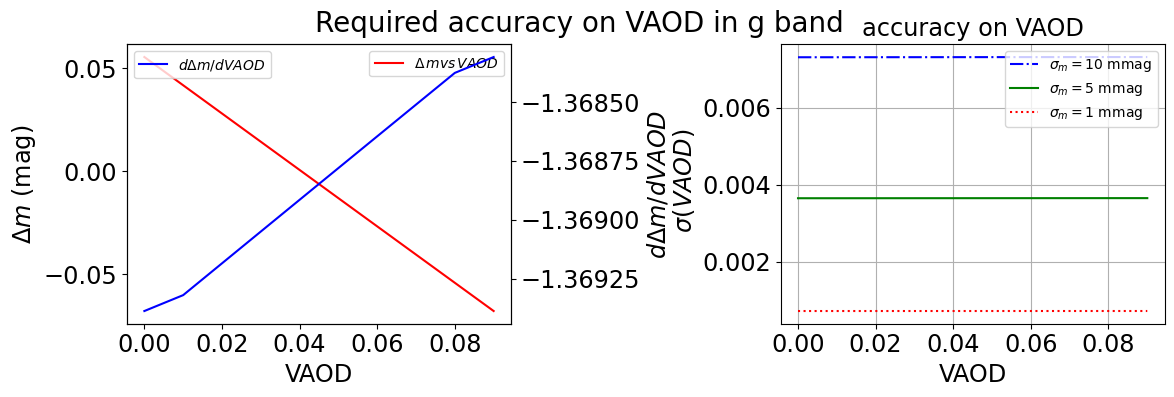

In [50]:
# Select filter
f_sel = 'g'
fig = plt.figure(figsize=(12,4))
ax = fig.add_subplot(1,2,1)
x = pc.allparameters
y = 2.5*np.log10(pc.allcollperfilter[f_sel]['II0ratio_nonstd'])
ax.set_xlabel("VAOD")
ax.set_ylabel("$\Delta m_1$")

ax.plot(x,y,'r-',label = "$\Delta \, m vs \, VAOD$")
ax.set_xlabel("VAOD")
ax.set_ylabel("$\Delta m$ (mag)")

ax2 = ax.twinx()
ax2.plot(x,np.gradient(y,x),'b-',label="$d\Delta m/ d VAOD$")
ax2.set_ylabel("$d\Delta m/ d VAOD$")
ax.legend(loc="best")
ax2.legend(loc="best")

ax = fig.add_subplot(1,2,2)
ax.plot(x,np.abs(1/np.gradient(y,x))*0.01,'b-.',label="$\sigma_m = 10$ mmag")
ax.plot(x,np.abs(1/np.gradient(y,x))*0.005,'g-',label="$\sigma_m = 5$ mmag")
ax.plot(x,np.abs(1/np.gradient(y,x))*0.001,'r:',label="$\sigma_m = 1$ mmag")
ax.legend()
ax.set_title("accuracy on VAOD")
ax.set_xlabel("VAOD")
ax.set_ylabel(" $\sigma(VAOD)$")
ax.grid()
plt.tight_layout()
plt.suptitle(f"Required accuracy on VAOD in {f_sel} band",fontsize="20")

- The accuracy o VAOD must be less than 0.3%